### Build PureTSM Model on Both Hasselt and Brussels Mobility Data

In [1]:
from math import sqrt
from numpy import concatenate
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import  matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

import pickle
import xgboost as xgb
import networkx as nx

In [2]:
# define the list of detectors, streets, and directions of valid channels
lst_detectors = ['ARL_103', 'ARL_203',  'BAI_TD1', 'BAI_TD2', 'BEL_TD4', 'BEL_TD5', 'BOT_TD2',    
                 'BE_TD1', 'LOU_TD1', 'LOU_TD2', 'MAD_103', 'MAD_203', 'ROG_TD1', 'ROG_TD2']   # 14 detectors

# Import the dataframe from the pickle file
df_jan = pd.read_pickle('../data/brussels_traffic_counting_20200122.pkl')
df_feb = pd.read_pickle('../data/Brussels_Mobility_Dataframe_Feb.pkl')
df_mar = pd.read_pickle('../data/Brussels_Mobility_Dataframe_Mar.pkl')

rush_hours = ['07:30', '07:45', '08:00', '08:15', '08:30', '08:45', '09:00', '15:15', '15:30', '15:45', '16:00',
              '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '18:00']

merge_column_name = 'start_time'
cols_to_drop_jan = ['speed', 'occupancy', 'end_time']
cols_to_drop_feb = ['scraper_id', 'lon_WGS_84', 'lat_WGS_84', 'speed', 'occupancy', 'end_time', 'start_time_utc', 
                    'end_time_utc', 'description_en']

num_timesteps = 8  # history window: 2 hours
pred_steps = 1  # prediction ahead: half an hour

In [3]:
df_dropped_jan = df_jan.drop(cols_to_drop_jan, axis=1)
df_dropped_jan.tail()

detector_code count        start_time
1199563        VP_103     2  2020/01/23 00:57
1199564        VP_203     3  2020/01/23 00:57
1199565       ARL_203     4  2020/01/23 00:57
1199566    SUL62_BDin  None                 -
1199567       BEL_TD5     1  2020/01/23 00:57

In [4]:
df_dropped_feb = df_feb.drop(cols_to_drop_feb, axis=1)
df_dropped_feb.head()

count        start_time detector_code
0   22.0  2020/02/01 01:00       ARL_203
1   24.0  2020/02/01 01:00        BE_TD1
2   14.0  2020/02/01 01:00       LOU_TD1
3   21.0  2020/02/01 01:00       MAD_203
4   18.0  2020/02/01 01:00       PNA_103

In [5]:
df_dropped_mar = df_mar.drop(cols_to_drop_feb, axis=1)
df_dropped_mar.tail()

count        start_time detector_code
78742   10.0  2020/03/11 00:58       LOU_TD1
78743   11.0  2020/03/11 00:58       MAD_203
78744    3.0  2020/03/11 00:58       PNA_103
78745    6.0  2020/03/11 00:58       ARL_203
78746    7.0  2020/03/11 00:58       TRO_TD1

In [6]:
def create_series_timestamps(start_datetime_str, end_datetime_str, column_name):
    datetime_start = datetime.strptime(start_datetime_str, '%Y/%m/%d %H:%M')
    datetime_end = datetime.strptime(end_datetime_str, '%Y/%m/%d %H:%M')

    # returns a timedelta object
    delta = datetime_end - datetime_start
    num_seconds = delta.days * 24 * 3600 + delta.seconds

    # returns minutes
    num_minutes = divmod(num_seconds, 60)[0]

    date_list = [(datetime_start + timedelta(minutes=x)).strftime("%Y/%m/%d %H:%M") for x in
                 range(num_minutes)]
    df_timestamps = pd.DataFrame(date_list, columns=[column_name])

    return df_timestamps


In [7]:
def load_and_visualize_raw_data(df_dropped, start_datetime_str, end_datetime_str): 
    
    df_timestamps = create_series_timestamps(start_datetime_str, end_datetime_str, merge_column_name)

    i = 0
    for detector in lst_detectors:

        df_detector = df_dropped[df_dropped['detector_code'] == detector]

        df_detector = pd.merge(df_timestamps, df_detector, on=['start_time'], how='left')

        # impute the missing values of 'count' as 0
        df_detector['count'] = df_detector['count'].fillna(0.0)
        df_detector['detector_code'] = detector
        df_detector.drop_duplicates(inplace=True)
        df_detector = df_detector.reset_index(drop=True)

        df_count_15min = df_detector.groupby(df_detector.index // 15).sum()
        df_detector_15min = df_detector.groupby(df_detector.index // 15).tail(1).reset_index(drop=True)
        df_detector_15min = df_detector_15min.drop(['count'], axis=1)

        df_detector_15min = pd.merge(df_detector_15min, df_count_15min, left_index=True, right_index=True)

        # Create new attrbutes
        df_detector_15min['Totaal_delta_1'] = df_detector_15min[['count']].diff(periods=1)
        df_detector_15min['Totaal_delta_2'] = df_detector_15min[['count']].diff(periods=2)

        df_detector_15min['DateTime'] = pd.to_datetime(df_detector_15min['start_time'], dayfirst=True)
        df_detector_15min['Time'] = df_detector_15min.apply(lambda row: row['start_time'][-5:], axis=1)

        df_detector_15min['day_of_week'] = df_detector_15min['DateTime'].dt.day_name()
        df_detector_15min['is_weekday'] = (df_detector_15min['DateTime'].dt.day_name() != 'Saturday') & (df_detector_15min['DateTime'].dt.day_name() != 'Sunday')
        df_detector_15min['is_wednesday'] = df_detector_15min['DateTime'].dt.day_name() == 'Wednesday'
        df_detector_15min['is_rushhour'] = df_detector_15min['Time'].isin(rush_hours) 


        df_detector_15min = df_detector_15min.drop(['start_time', 'Time'], axis=1)
        df_detector_15min.rename(columns = {'count':'Totaal Abs.', 'detector_code': 'Detector_Code'}, inplace = True) 

        if i == 0:
            df_test = df_detector_15min

        else:
            df_test = df_test.append(df_detector_15min, ignore_index = True) 
        i += 1     


        # Plot the prediction vs. test set
        plt.figure(figsize=(12, 4))
        plt.title(f'Prediction vs. Actual for channel for {detector}', fontsize=12)
        plt.plot(df_detector_15min['Totaal Abs.'], label="Actual")
        plt.xlabel("Time")
        plt.ylabel("Traffic Counts")
        plt.legend()
        # plt.grid(True)
        plt.show()    
        
    return df_test

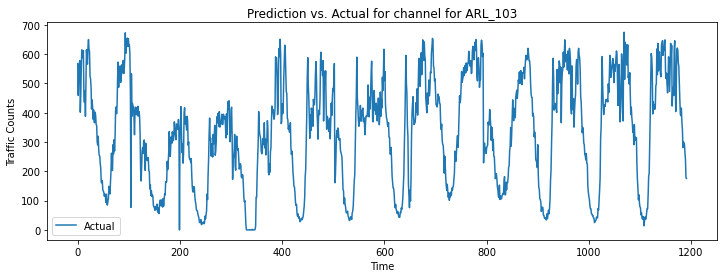

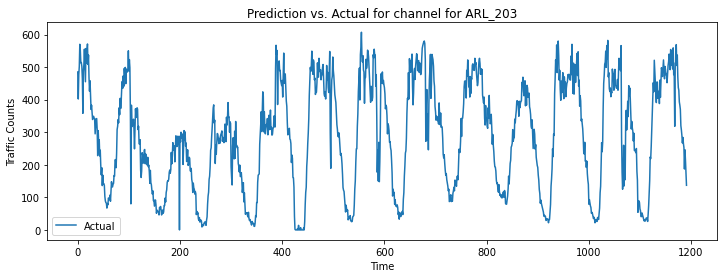

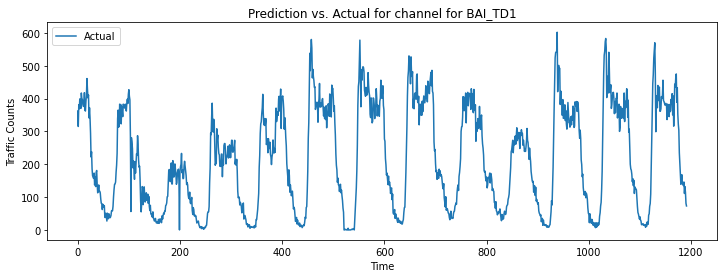

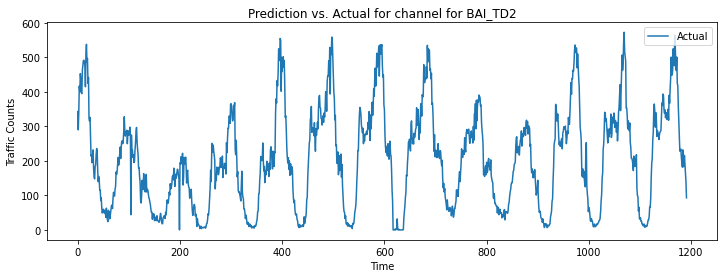

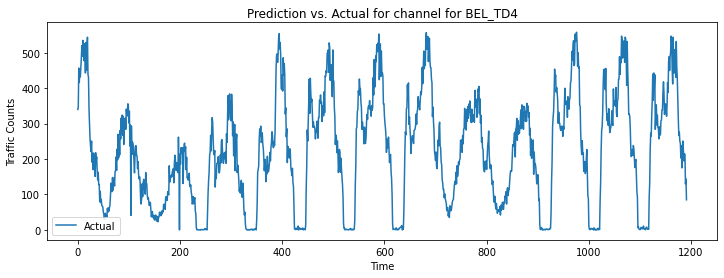

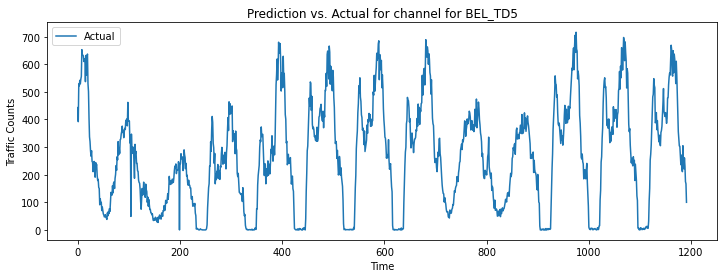

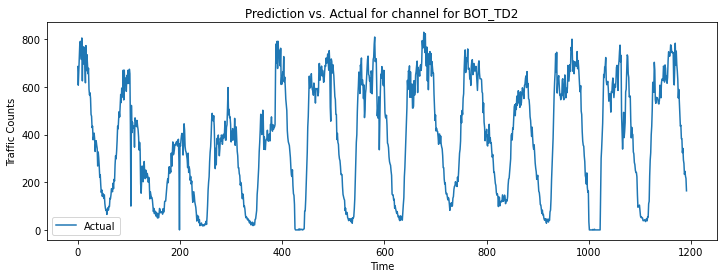

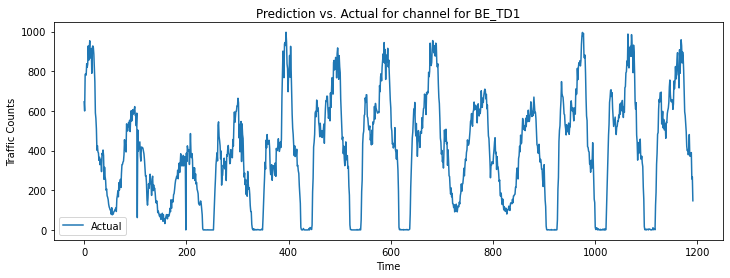

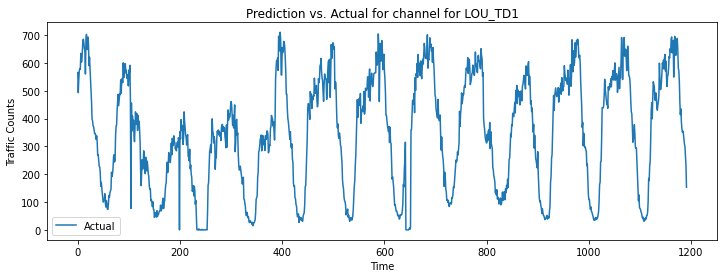

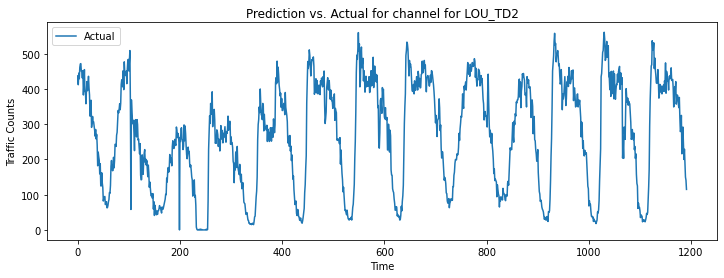

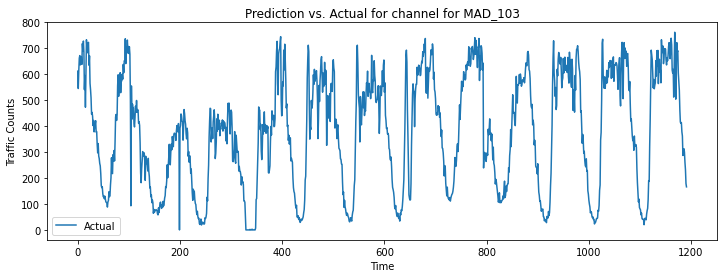

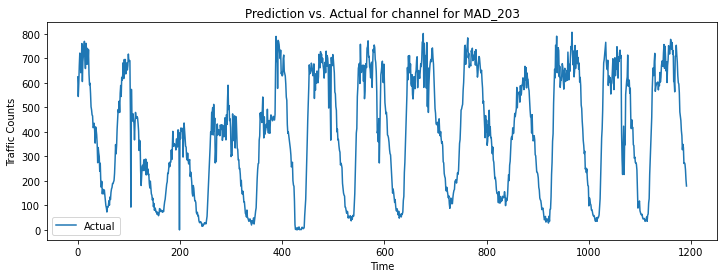

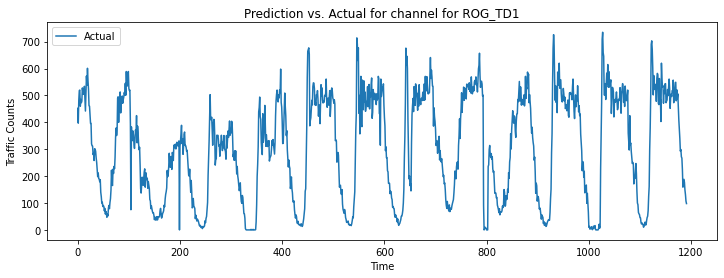

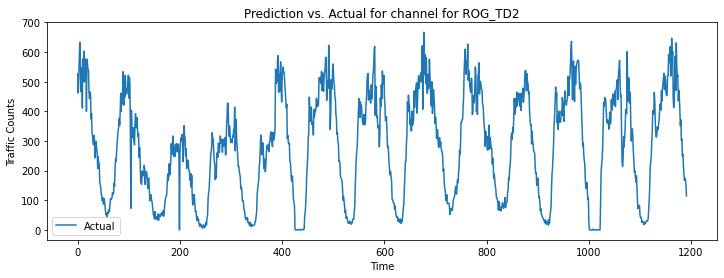

In [8]:
# Create the dataframe in 15 min time resolution for Jan. 2020
start_datetime_str = '2020/01/10 14:01'
end_datetime_str = '2020/01/23 00:01'

df_15min_jan = load_and_visualize_raw_data(df_dropped_jan, start_datetime_str, end_datetime_str)


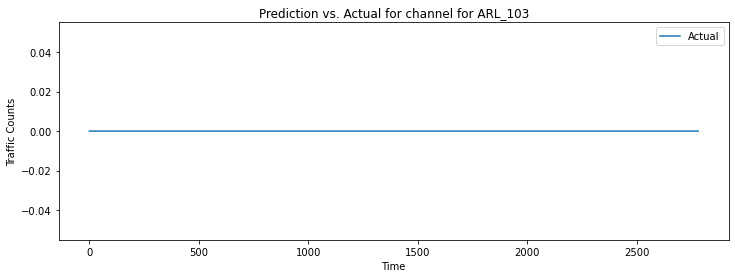

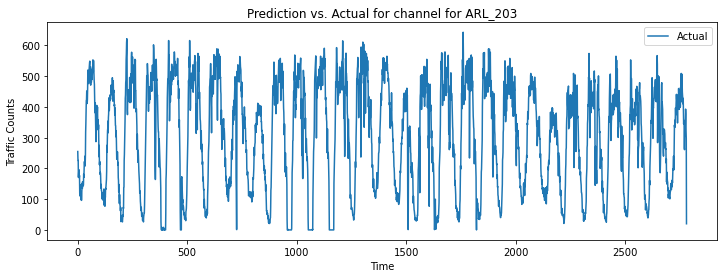

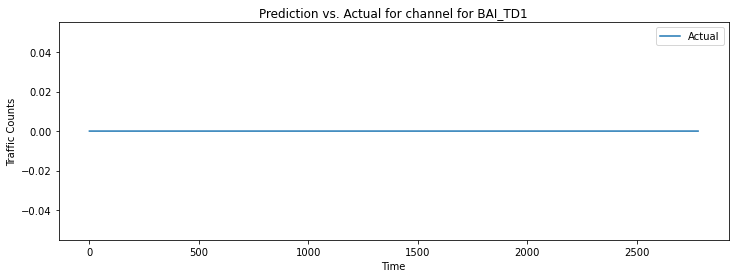

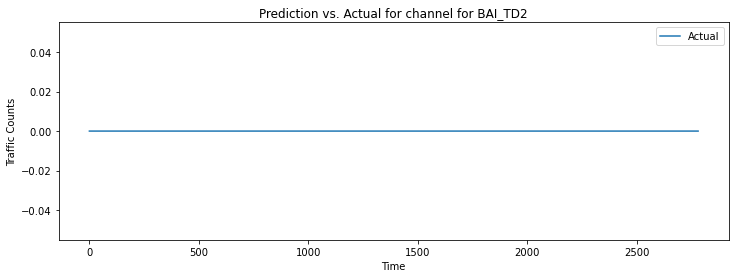

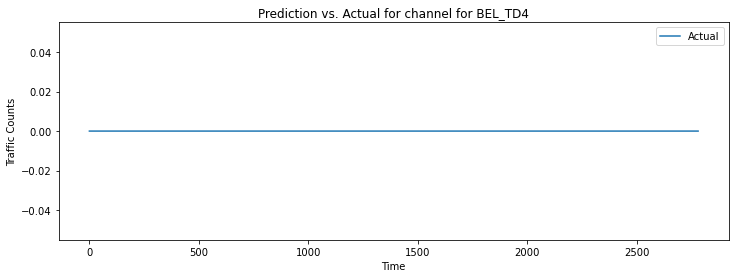

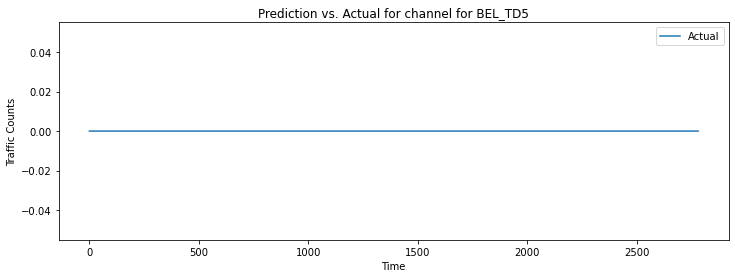

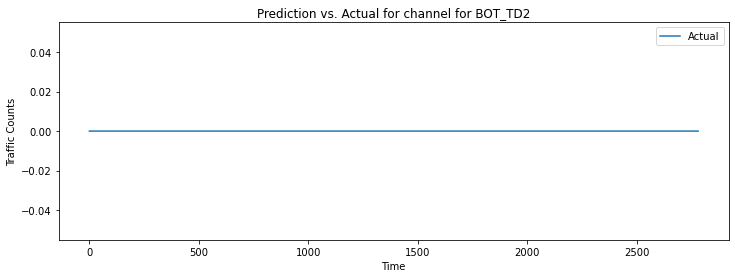

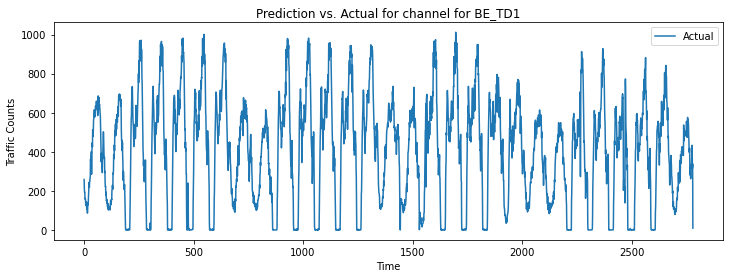

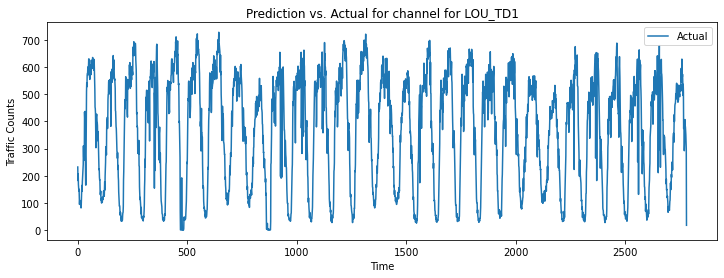

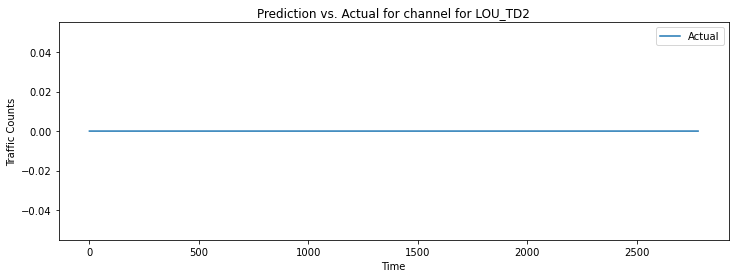

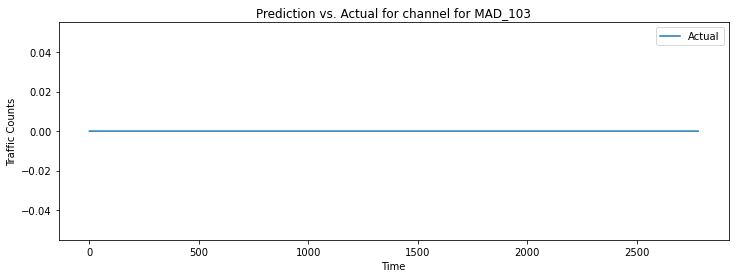

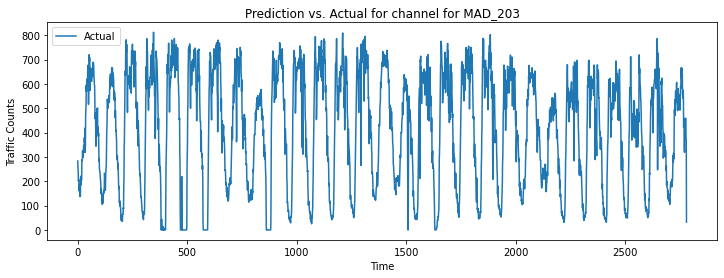

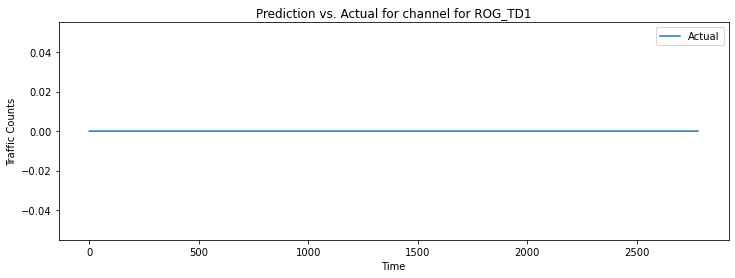

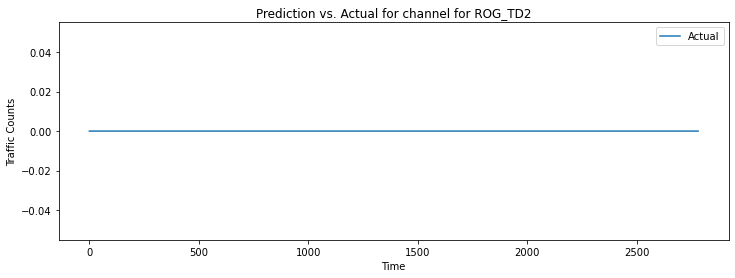

In [9]:
# Create the dataframe in 15 min time resolution for Feb. 2020
start_datetime_str_2 = '2020/02/01 01:00'
end_datetime_str_2 = '2020/03/01 00:01'

df_15min_feb = load_and_visualize_raw_data(df_dropped_feb, start_datetime_str_2, end_datetime_str_2)


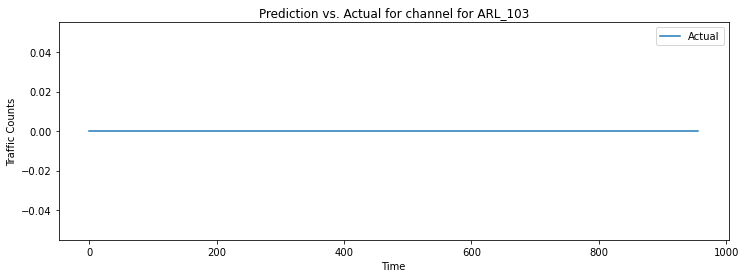

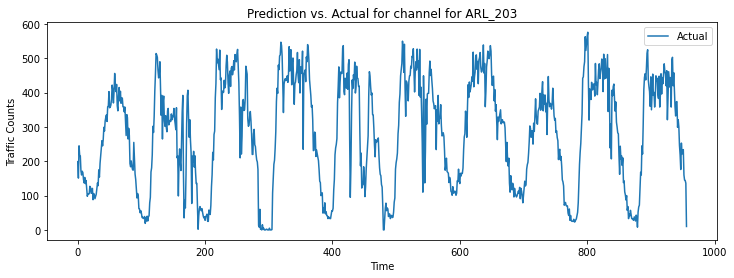

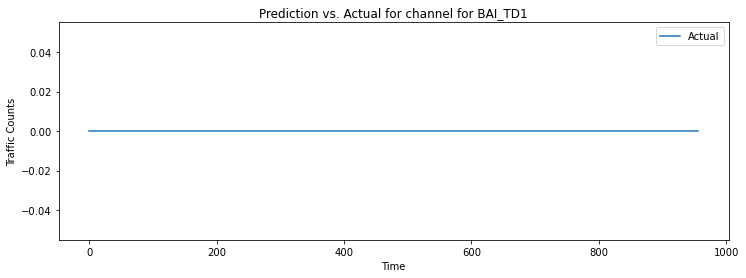

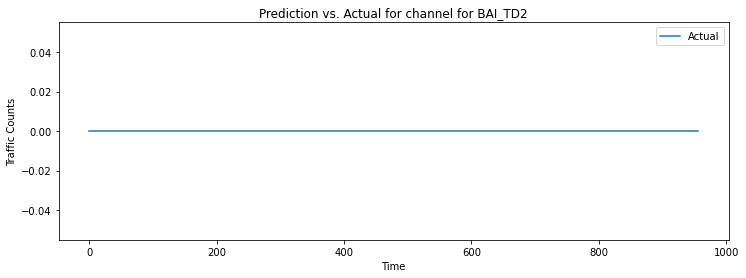

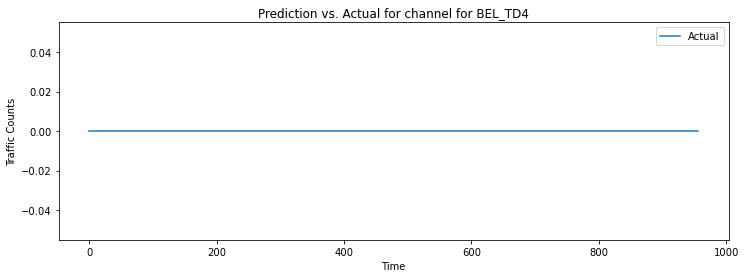

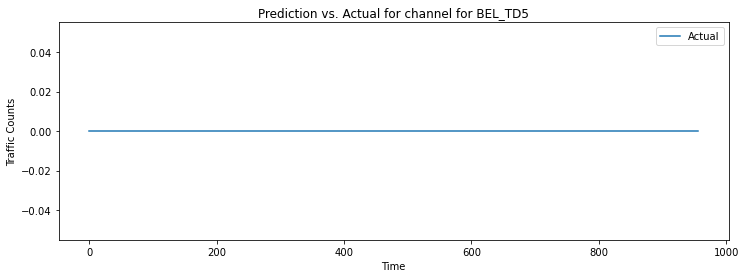

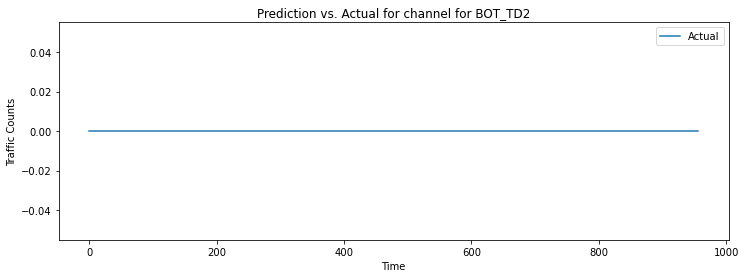

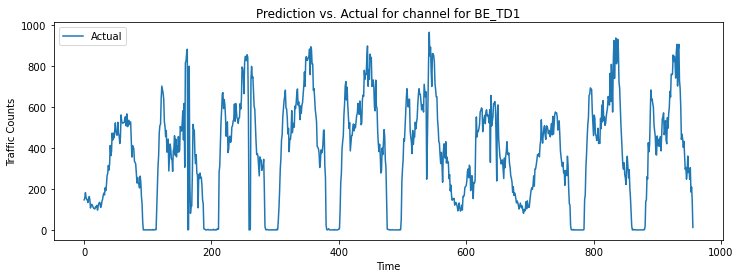

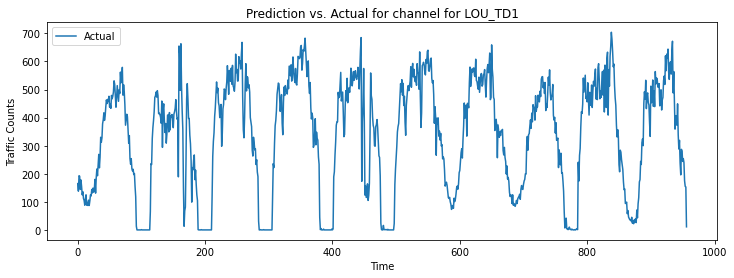

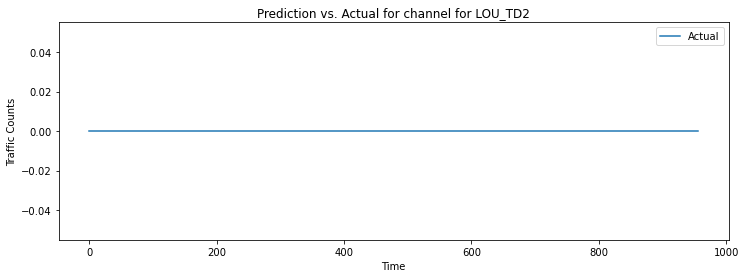

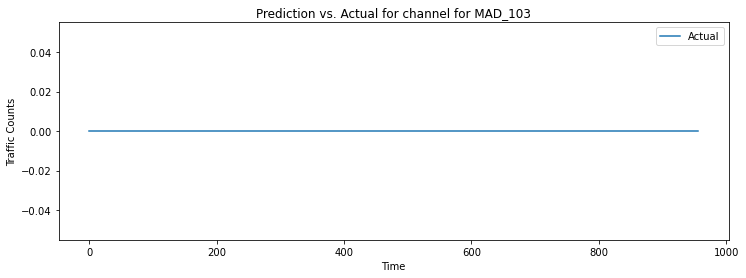

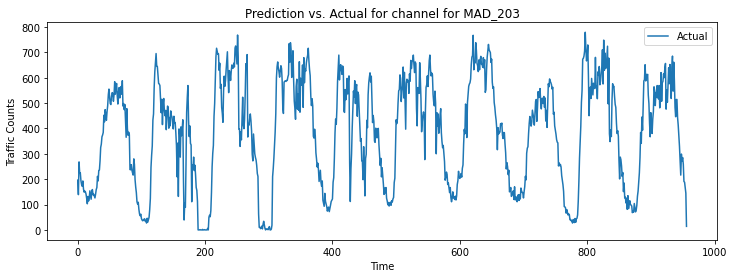

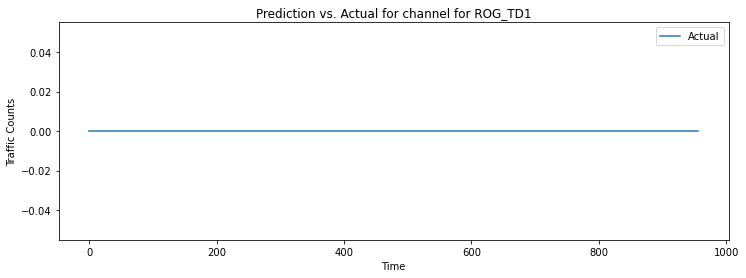

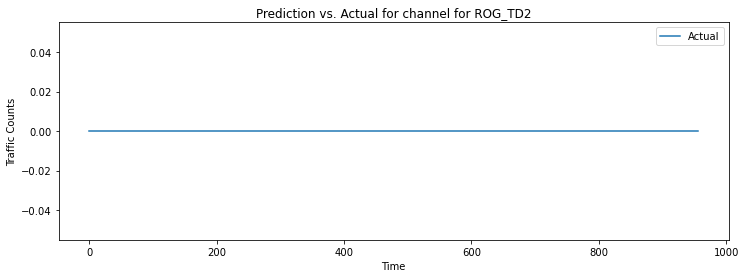

In [10]:
# Create the dataframe in 15 min time resolution for Mar. 2020
start_datetime_str_3 = '2020/03/01 01:00'
end_datetime_str_3 = '2020/03/11 00:01'

df_15min_mar = load_and_visualize_raw_data(df_dropped_mar, start_datetime_str_3, end_datetime_str_3)

In [11]:
def load_pickle(filename):
    d = None
    with open(filename, mode='rb') as f:
        d = pickle.load(f)
    return d

def get_weight_dicts(graph_file, lst_detectors):
    graph = load_pickle(graph_file)

    detector_to_edge = dict()
    lst_valid_detectors = []

    for u, v, edge_data in graph.edges(data=True):
        if 'detector_info' in edge_data:
            detector_info = edge_data['detector_info']
            detector_id = detector_info['id']
            if detector_id in lst_detectors:
                detector_to_edge[detector_id] = (u, v)
                lst_valid_detectors.append(detector_id)

    dict_in_weights = dict()
    for detector_id, (u, v) in detector_to_edge.items():
        dict_in_weights[detector_id] = dict()
        dict_weights = dict_in_weights[detector_id]
        for detector_id_n, (u_n, v_n) in detector_to_edge.items():
            # the channel itself and the opposite channel are not taken into account in computing neighbouring influence
            if detector_id == detector_id_n:
            # if detector_id == detector_id_n:
                dict_weights[detector_id_n] = 0.0
            else:
                try:
                    path = nx.shortest_path(graph, source=v_n, target=u, weight='length')
                    path_length_meters = sum([graph.get_edge_data(path[i], path[i + 1])['length']
                                              for i in range(len(path) - 1)])
                    if path_length_meters == 0:
                        dict_weights[detector_id_n] = 1.0
                    else:
                        dict_weights[detector_id_n] = 1.0 / path_length_meters
                except nx.NetworkXNoPath:
                    dict_weights[detector_id_n] = 0.0

    dict_out_weights = dict()
    for detector_id, (u, v) in detector_to_edge.items():
        dict_out_weights[detector_id] = dict()
        dict_weights = dict_out_weights[detector_id]
        for detector_id_n, (u_n, v_n) in detector_to_edge.items():
            # the channel itself and the opposite channel are not taken into account in computing neighbouring influence
            if detector_id == detector_id_n:
            # if detector_id == detector_id_n:
                dict_weights[detector_id_n] = 0.0
            else:
                try:
                    path = nx.shortest_path(graph, source=v, target=u_n, weight='length')
                    path_length_meters = sum([graph.get_edge_data(path[i], path[i + 1])['length']
                                              for i in range(len(path) - 1)])
                    if path_length_meters == 0:
                        dict_weights[detector_id_n] = 1.0
                    else:
                        dict_weights[detector_id_n] = 1.0 / path_length_meters
                except nx.NetworkXNoPath:
                    dict_weights[detector_id_n] = 0.0

    return lst_valid_detectors, dict_in_weights, dict_out_weights                    


# Load the graph from a pickle file, and get the incoming/outgoing weights for each detector
graph_file = '../data/brussels_graph.bin'

valid_detectors, weights_in, weights_out = get_weight_dicts(graph_file, lst_detectors)

In [12]:
def series_to_supervised(data, target, n_lags=1, n_leads=0, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a Pandas DataFrame.
        tareget: List of the target column names.
        n_lags: Number of lags for the observations (X). (n>=1; time steps: [-n,-n+1,..., -1] )
        n_leads: Number of time steps ahead for the prediction (y). (n>=0; time step: n; 0 is the index of "now")
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame for supervised learning.
    """

    df_tars = data[[target]]
    df_vars = data

    n_tars = df_tars.shape[1]
    n_vars = data.shape[1]

    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_lags, 0, -1):
        cols.append(data.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]

    # forecast sequence (t+n)
    if n_leads == 0:
        cols.append(df_tars)
        names += [('tar%d(t)' % (j + 1)) for j in range(n_tars)]
    else:
        cols.append(df_tars.shift(-n_leads))
        names += [('tar%d(t+%d)' % (j + 1, n_leads)) for j in range(n_tars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def get_features_neighbouring_channels(df, channel, lst_valid_channels, weights):
    """
    Get vehicle count features from the data for neighbouring channels,
    by using the weights on the edges of the graph.
    """

    # get the DateTime series of the data for the channel being processed
    df_temp = df[df['Detector_Code'] == channel]
    df_neighbours = df_temp[['DateTime']]

    dict_weights_for_ch = weights[channel]
    i = 0
    column_list = []
    for other_ch in dict_weights_for_ch:
        # Get the vehicle count features for a different channel
        df_other_ch = df[df['Detector_Code'] == other_ch]
        if df_other_ch.shape[0] == 0 or other_ch == channel:
            continue
        df_other_ch = df_other_ch[['DateTime', 'Totaal Abs.']]
        df_other_ch['Weighted_Total'] = df_other_ch['Totaal Abs.'] * dict_weights_for_ch[other_ch]
        df_other_ch = df_other_ch.drop(['Totaal Abs.'], axis=1)
        df_other_ch.columns = ['DateTime', 'W_Total_n_' + str(i)]
        column_list.append('W_Total_n_' + str(i))
        # Join the vehicle count features for other detectors at each time stamp
        df_neighbours = pd.merge(df_neighbours, df_other_ch, on=['DateTime'], how='left')
        i += 1

    # df_neighbours.set_index('DateTime')

    df_neighbours['sum'] = df_neighbours[column_list].sum(axis=1)
    df_neighbours['max'] = df_neighbours[column_list].max(axis=1)
    # df_neighbours['min'] = df_neighbours[column_list].min(axis=1)
    df_neighbours['avg'] = df_neighbours[column_list].mean(axis=1)
    df_neighbours['std'] = df_neighbours[column_list].std(axis=1)

    df_neighbours_features = df_neighbours.drop(column_list, axis=1)

    return df_neighbours_features


def prepare_graph_based_features(df, lst_valid_detectors, weights_in, weights_out):

    lst_build_df = []
    dict_test_df = {}

    for detector in lst_valid_detectors:
        # Get the data for the specific channel
        df_for_detector = df[df['Detector_Code'] == detector]

        # For some channels, the data extraction time range is different from others.
        # Such channels have been removed in the imported dataframe.
        if df_for_detector.shape[0] == 0:
            continue

        # Get the vehicle count features from the data for other channels
        df_other_channels_in = get_features_neighbouring_channels(df, detector, lst_valid_detectors, weights_in)
        df_other_channels_in.columns = ['DateTime', 'sum_in', 'max_in', 'avg_in', 'std_in']

        df_other_channels_out = get_features_neighbouring_channels(df, detector, lst_valid_detectors, weights_out)
        df_other_channels_out.columns = ['DateTime', 'sum_out', 'max_out', 'avg_out', 'std_out']

        df_enriched = pd.merge(df_for_detector, df_other_channels_in, on=['DateTime'], how='left')
        df_enriched = pd.merge(df_enriched, df_other_channels_out, on=['DateTime'], how='left')

        # Drop the columns that are not used for training
        col_to_drop = ['Detector_Code', 'day_of_week']
        df_enriched = df_enriched.drop(col_to_drop, axis=1)
        
        df_enriched_train = df_enriched[df_enriched['DateTime'] < '2020/01/22 00:00']
        df_enriched_test = df_enriched[df_enriched['DateTime'] >= '2020/01/22 00:00']

        test_x_axis = df_enriched_test['DateTime']
        test_x_arr = test_x_axis.apply(str).to_numpy()[num_timesteps + pred_steps:]
        
        # print(df_enriched.head())

        # Create the multivariate feature set with historical window for the test set
        df_enriched_train = df_enriched_train.drop(['DateTime'], axis=1)
        df_enriched_test = df_enriched_test.drop(['DateTime'], axis=1)
        
        columns_reorder = ['Totaal Abs.', 'Totaal_delta_1', 'Totaal_delta_2', 'is_weekday', 'is_wednesday', 'is_rushhour', 
                           'sum_in', 'max_in', 'avg_in', 'std_in', 'sum_out', 'max_out', 'avg_out', 'std_out']
        df_enriched_train = df_enriched_train.reindex(columns=columns_reorder)
        df_enriched_test = df_enriched_test.reindex(columns=columns_reorder)
        
        num_feaures = df_enriched_test.shape[1]
        
        df_windowed_train = series_to_supervised(df_enriched_train, 'Totaal Abs.', n_lags=num_timesteps,
                                               n_leads=pred_steps, dropnan=True)
        
        df_windowed_test = series_to_supervised(df_enriched_test, 'Totaal Abs.', n_lags=num_timesteps,
                                               n_leads=pred_steps, dropnan=True)

        # Add the test set to the return dict
        lst_build_df.append(df_windowed_train)
        dict_test_df[detector] = (test_x_arr, df_windowed_test)

    return num_feaures, lst_build_df, dict_test_df



# Construct the build and test sets for different months
num_feaures, lst_train_df, dict_test_df = prepare_graph_based_features(df_15min_jan, valid_detectors, weights_in, weights_out)


In [13]:
num_feaures

14

In [14]:
dict_train_df['ARL_203'].head()

NameError: name 'dict_train_df' is not defined

In [15]:
dict_test_df['ARL_203'][1].head()

var1(t-8)  var2(t-8)  var3(t-8) var4(t-8) var5(t-8) var6(t-8)  \
1103      153.0      -27.0      -97.0      True      True     False   
1104       54.0      -99.0     -126.0      True      True     False   
1105       86.0       32.0      -67.0      True      True     False   
1106       89.0        3.0       35.0      True      True     False   
1107       84.0       -5.0       -2.0      True      True     False   

      var7(t-8)  var8(t-8)  var9(t-8)  var10(t-8)  ...  var6(t-1)  var7(t-1)  \
1103   0.991679   0.269041   0.076283    0.073172  ...      False   0.300995   
1104   0.682028   0.222115   0.052464    0.062099  ...      False   0.303049   
1105   0.560929   0.161112   0.043148    0.046031  ...      False   0.246135   
1106   0.598108   0.187703   0.046008    0.053058  ...      False   0.216952   
1107   0.493062   0.142341   0.037928    0.040653  ...      False   0.227109   

      var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1) var13(t-1)  \
1103   0.079774   0.023153    0.023547    0.417119    0.176734   0.032086   
1104   0.090723   0.023311    0.026947    0.413142    0.173929   0.031780   
1105   0.064132   0.018933    0.019556    0.371254    0.179540   0.028558   
1106   0.057875   0.016689    0.017026    0.328726    0.145876   0.025287   
1107   0.071953   0.017470    0.020139    0.303619    0.126239   0.023355   

     var14(t-1) tar1(t+1)  
1103   0.047665      52.0  
1104   0.047805      46.0  
1105   0.048688      41.0  
1106   0.040145      33.0  
1107   0.034315      28.0  

[5 rows x 113 columns]

In [16]:
# load Hasselt data sets
bulid_sets_sept_file = "../data/hasselt_build_sets_sept.pkl"
test_sets_sept_file = "../data/hasselt_test_sets_sept.pkl"

lst_train_df_hasselt_sept = pickle.load(open(bulid_sets_sept_file, "rb"))
dict_test_df_hasselt_sept = pickle.load(open(test_sets_sept_file, "rb"))

bulid_sets_nov_file = "../data/hasselt_build_sets_nov.pkl"
test_sets_nov_file = "../data/hasselt_test_sets_nov.pkl"

lst_train_df_hasselt_nov = pickle.load(open(bulid_sets_nov_file, "rb"))
dict_test_df_hasselt_nov = pickle.load(open(test_sets_nov_file, "rb"))


#### Build prediction model by using both Hasselt and Brussels data

In [17]:
# Generate build set
i = 0

# Hasselt data
for df_build_for_detector in lst_train_df_hasselt_sept:
    if i == 0:
        df_build = df_build_for_detector
    else:
        df_build = df_build.append(df_build_for_detector, ignore_index=True)
    i += 1

for df_build_for_detector in lst_train_df_hasselt_nov:
    df_build = df_build.append(df_build_for_detector, ignore_index=True)

print(df_build.shape)

# Brussels data
for df_build_for_detector in lst_train_df:
    df_build = df_build.append(df_build_for_detector, ignore_index=True)
    
print(df_build.shape)

# Convert dataframe of build set to a Numpy array
df_build_f32 = df_build.astype('float32')

scaler = StandardScaler()
arr_build = scaler.fit_transform(df_build_f32)

# Then, shuffle the build set and split it into training and validation sets
np.random.shuffle(arr_build)
np.random.shuffle(arr_build)

# split into input and outputs
train_X, train_y = arr_build[:, :-1], arr_build[:, -1]
# valid_X, valid_y = arr_valid[:, :-1], arr_valid[:, -1]

print(train_X.shape, train_y.shape)



(34560, 113)
(49736, 113)
(49736, 112) (49736,)


In [18]:
# Build PureTSM model

print('\nModeling for the PureTSM ...')
    
def algorithm_pipeline(X_train_data, y_train_data,
                       model, param_grid, cv=10, scoring_fit='r2',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    return fitted_model

    
model = xgb.XGBRegressor()

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'colsample_bytree': [0.2, 0.3, 0.4, 0.5, 0.6],
    'max_depth': [5, 6, 8, 10, 12],
    # 'reg_alpha': [1.1, 1.2, 1.3],
    # 'reg_lambda': [1.1, 1.2, 1.3],
    # 'subsample': [0.7, 0.8, 0.9]
}


# param_grid = {
#     'n_estimators': [300],
#     'colsample_bytree': [0.4],
#     'max_depth': [8],
#     'reg_alpha': [1.3],
#     'reg_lambda': [1.3],
#     # 'subsample': [0.7, 0.8, 0.9]
# }

model = algorithm_pipeline(train_X, train_y, model, param_grid, cv=10)    
    
# Root Mean Squared Error
print(model.best_score_)
print(model.best_params_)    



Modeling for the PureTSM ...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 64.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 123.2min finished


[14:21:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9748142534588322
{'colsample_bytree': 0.3, 'max_depth': 8, 'n_estimators': 400}


#### Test on Brussels test set

In [19]:
# Create the time series for each channel and pre-process the data
for detector in dict_df_test:
    
    test_x_arr = dict_df_test[detector][0]
    df_detector = dict_df_test[detector][1]

    df_test_f32 = df_detector.astype('float32')
    
    data_arr_test = scaler.transform(df_test_f32)
    
    test_X, test_y = data_arr_test[:, :-1], data_arr_test[:, -1]
    
    # ---------------- Make a prediction on the test set and evaluate the rusult. 
    test_y_pred = model.predict(test_X)
    test_y_pred = test_y_pred.reshape((len(test_y_pred), 1))
    # test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, test_y_pred), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_X, test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]

    # calculate RMSE and R^2
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    r2 = r2_score(inv_y, inv_yhat)
    print('Test RMSE: %.3f' % rmse)
    print('Test R^2: %.3f' % r2)

    # Plot the prediction vs. test set
    plt.figure(figsize=(12, 4))
    plt.title(f'Prediction vs. Actual for detector {detector}', fontsize=12)
    plt.plot(inv_y, label="Actual")
    plt.plot(inv_yhat, label="Prediction")
    plt.xticks(np.arange(0, len(test_x_arr), step=4),test_x_arr[::4], rotation=60)
    plt.xlabel("Time")
    plt.ylabel("Vehicle Counts")
    plt.legend()
    # plt.grid(True)
    plt.show()  

NameError: name 'dict_df_test' is not defined

#### Test on Hasselt data for Sept. 2019

In [20]:
lst_channels = [['R3969_ch_1', 'R3969', 'Lazarijstraat', 'Armand Hertzstraat', 'Lazarijstraat'],
                ['R3969_ch_2', 'R3969', 'Lazarijstraat', 'Lazarijstraat', 'Armand Hertzstraat'],
                ['R3971_ch_1', 'R3971', 'Manteliusstraat', 'Melkvoetstraat', 'Burg. Bollenstraat'],
                ['R3971_ch_2', 'R3971', 'Manteliusstraat', 'Burg. Bollenstraat', 'Melkvoetstraat'],
                ['R3972_ch_1', 'R3972', 'Palmstraat', 'Lazarijstraat', 'Plantenstraat'],
                ['R3972_ch_2', 'R3972', 'Palmstraat', 'Plantenstraat', 'Lazarijstraat'],
                ['R3973_ch_1', 'R3973', 'Burgemeester Bollenstraat', 'Koningin Astridlaan', 'Manteliusstraat'],
                ['R3973_ch_2', 'R3973', 'Burgemeester Bollenstraat', 'Manteliusstraat', 'Koningin Astridlaan'],
                # ['R3974', 'Gazometerstraat', 'Manteliusstraat', 'Stokerijstraat'],
                ['R3975_ch_1', 'R3975', 'Stokerijstraat', 'Armand Hertzstraat', 'Blijde-Inkomststraat'],
                ['R3975_ch_2', 'R3975', 'Stokerijstraat', 'Blijde-Inkomststraat', 'Armand Hertzstraat'],
                ['R3976_ch_1', 'R3976', 'Plantenstraat', 'Palmstraat', 'Oude Kuringerbaan'],
                ['R3976_ch_2', 'R3976', 'Plantenstraat', 'Oude Kuringerbaan', 'Palmstraat'],
                ['R3977_ch_1', 'R3977', 'Lazarijstraat', 'Palmstraat', 'Oude Kuringerbaan'],
                ['R3977_ch_2', 'R3977', 'Lazarijstraat', 'Oude Kuringerbaan', 'Palmstraat'],
                ['R3978_ch_1', 'R3978', 'Plantenstraat', 'Anne Ruttenstraat', 'Heilig Hartplein'],
                ['R3978_ch_2', 'R3978', 'Plantenstraat', 'Heilig Hartplein', 'Anne Ruttenstraat']]

df_channels = pd.DataFrame(lst_channels, columns=['Channel', 'Detector_Code', 'Street', 'Start', 'End'])

Test RMSE: 3.819
Test R^2: 0.759


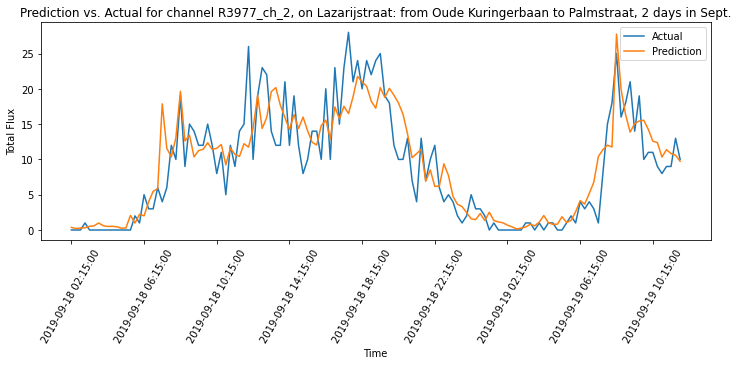

Test RMSE: 5.900
Test R^2: 0.823


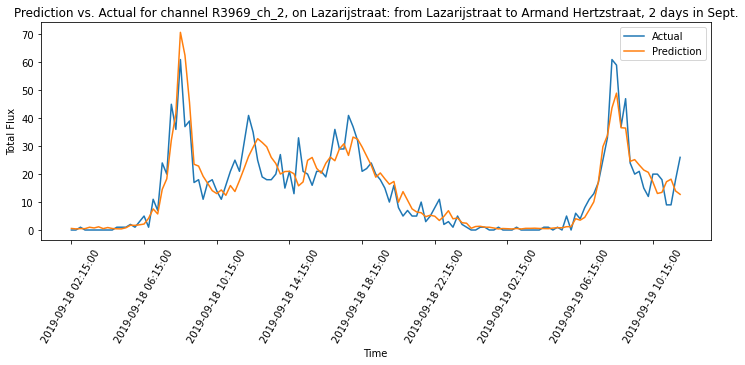

Test RMSE: 7.686
Test R^2: 0.720


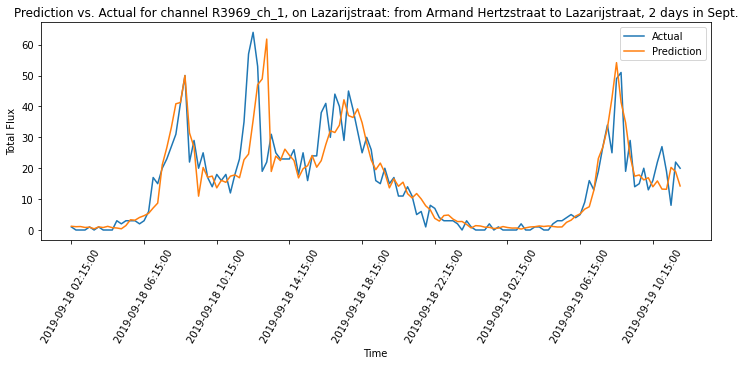

Test RMSE: 4.560
Test R^2: 0.708


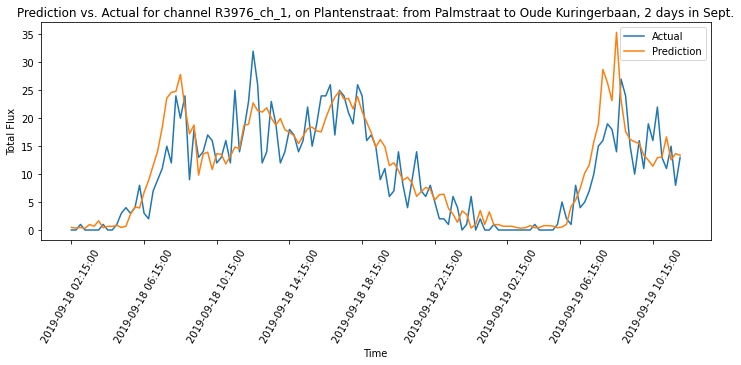

Test RMSE: 4.731
Test R^2: 0.840


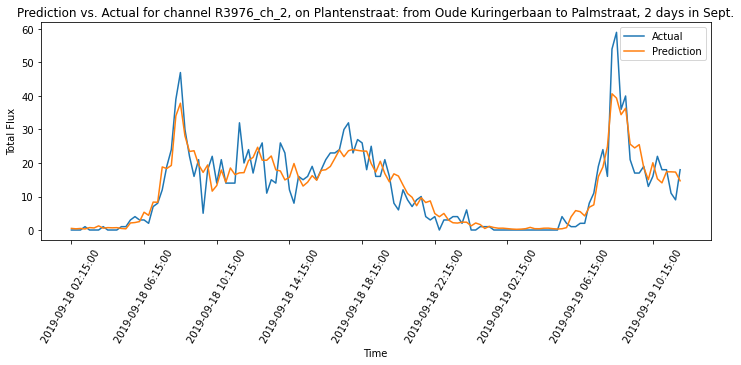

Test RMSE: 6.160
Test R^2: 0.798


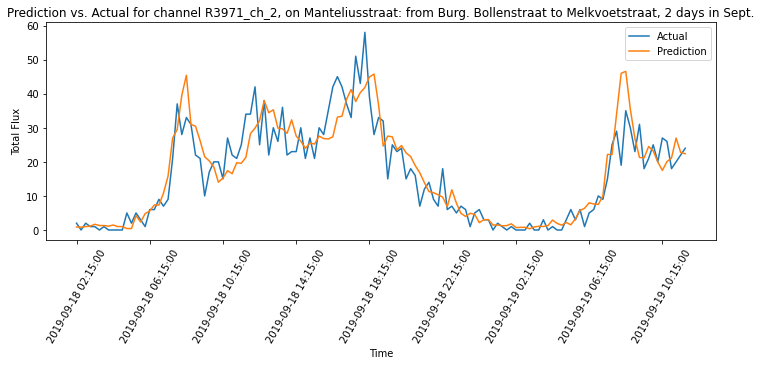

Test RMSE: 6.174
Test R^2: 0.797


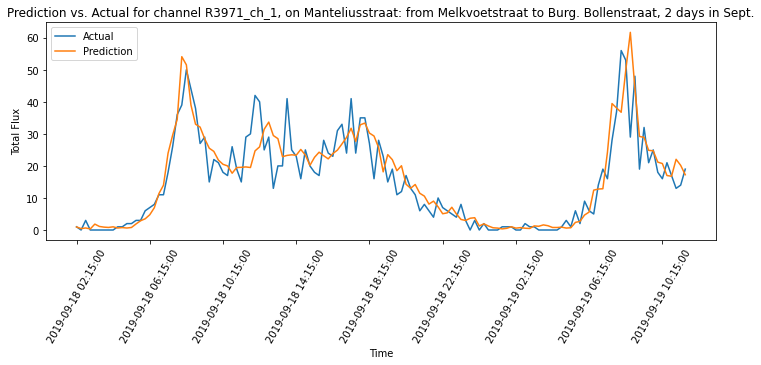

Test RMSE: 4.623
Test R^2: 0.785


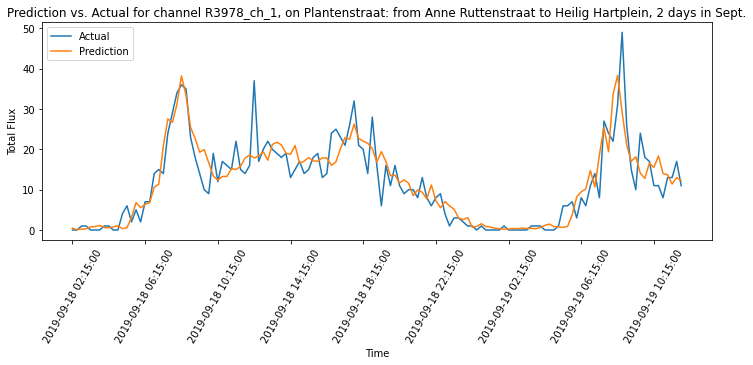

Test RMSE: 3.226
Test R^2: 0.704


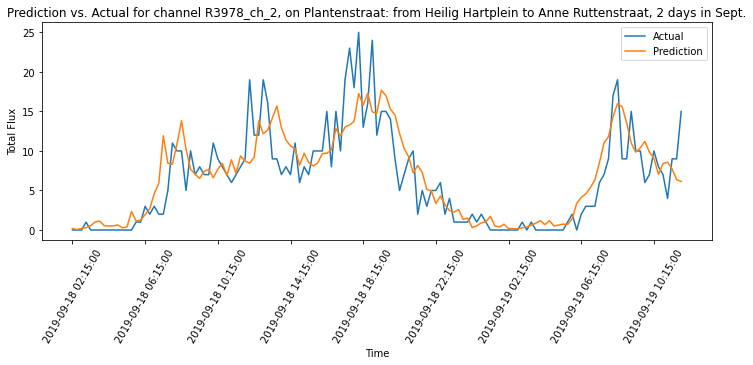

Test RMSE: 4.999
Test R^2: 0.788


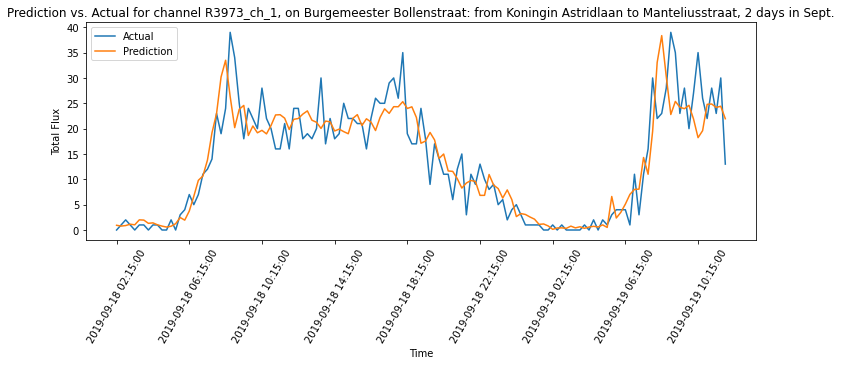

Test RMSE: 7.422
Test R^2: 0.765


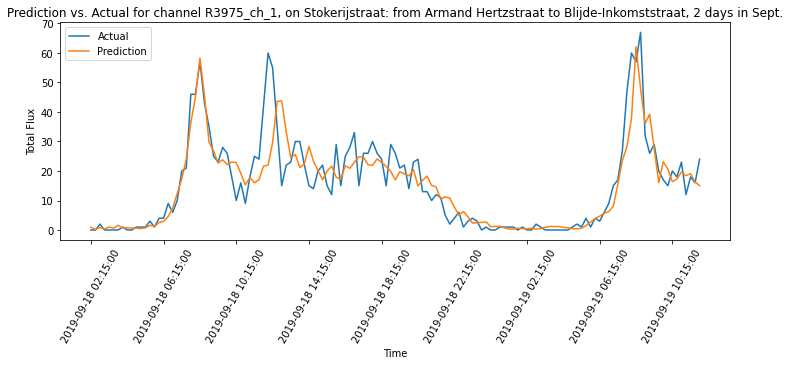

Test RMSE: 2.528
Test R^2: 0.352


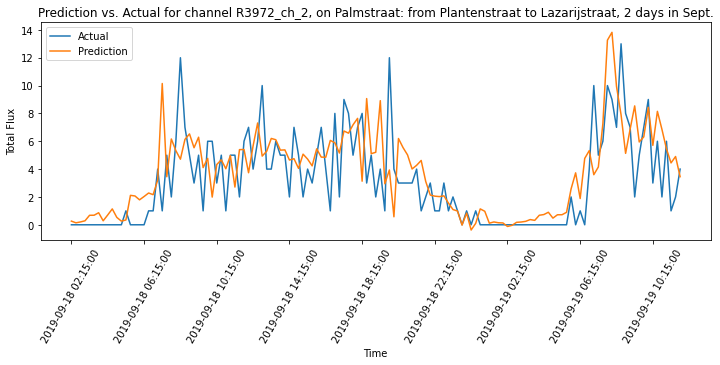

Test RMSE: 4.983
Test R^2: 0.834


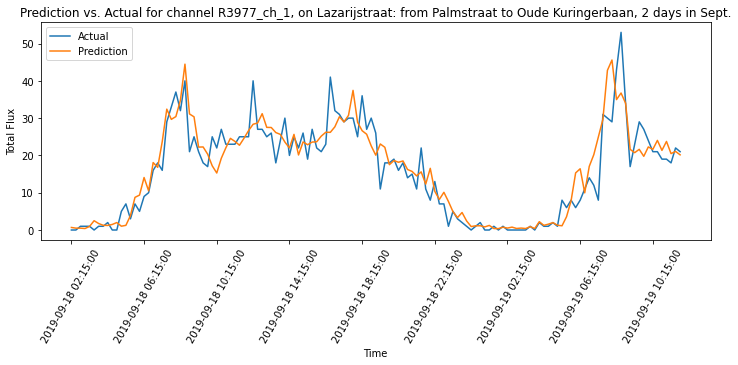

Test RMSE: 2.867
Test R^2: 0.649


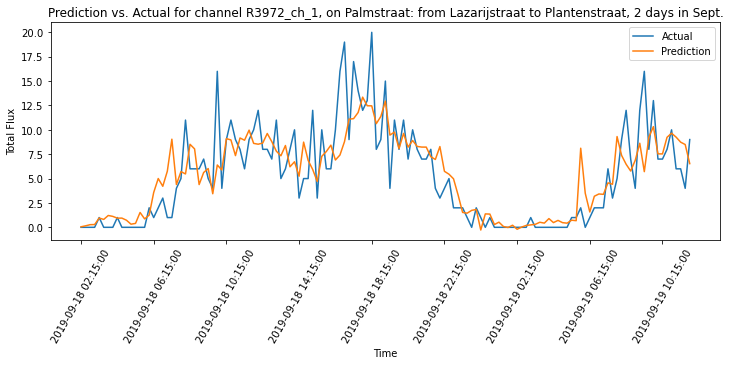

In [21]:
for key in dict_test_df_hasselt_sept:
    df_channel = df_channels[df_channels['Channel'] == key]
    street = df_channel['Street'].iloc[0]
    start = df_channel['Start'].iloc[0]
    end = df_channel['End'].iloc[0]
  
    (test_x_arr, df_test) = dict_test_df_hasselt_sept[key]
    df_test_f32 = df_test.astype('float32')
    data_arr_test = scaler.transform(df_test_f32)
    test_X, test_y = data_arr_test[:, :-1], data_arr_test[:, -1]
    # test_X = test_X.reshape((test_X.shape[0], num_timesteps, num_feaures))
    
    # ---------------- Make a prediction on the test set and evaluate the rusult for Sept. 
    test_y_pred = model.predict(test_X)
    test_y_pred = test_y_pred.reshape((len(test_y_pred), 1))
    # test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, test_y_pred), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_X, test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]

    # calculate RMSE and R^2
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    r2 = r2_score(inv_y, inv_yhat)
    print('Test RMSE: %.3f' % rmse)
    print('Test R^2: %.3f' % r2)

    # Plot the prediction vs. test set
    plt.figure(figsize=(12, 4))
    plt.title(f'Prediction vs. Actual for channel {key}, on {street}: from {start} to {end}, 2 days in Sept.', fontsize=12)
    plt.plot(inv_y, label="Actual")
    plt.plot(inv_yhat, label="Prediction")
    plt.xticks(np.arange(0, len(test_x_arr), step=16),test_x_arr[::16], rotation=60)
    plt.xlabel("Time")
    plt.ylabel("Total Flux")
    plt.legend()
    # plt.grid(True)
    plt.show()    


#### Test on Hasselt data for Nov. 2019

Test RMSE: 4.516
Test R^2: 0.690


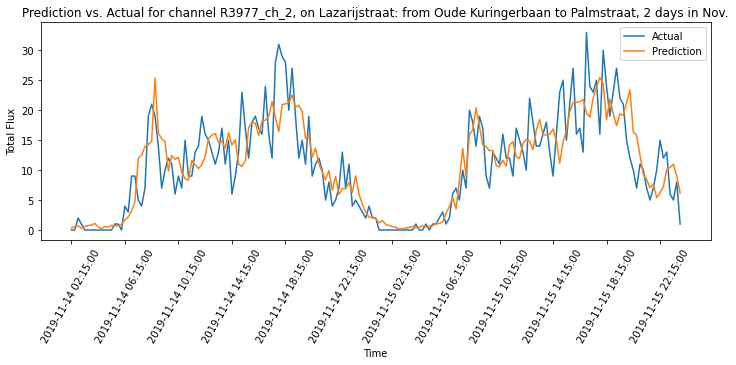

Test RMSE: 7.526
Test R^2: 0.723


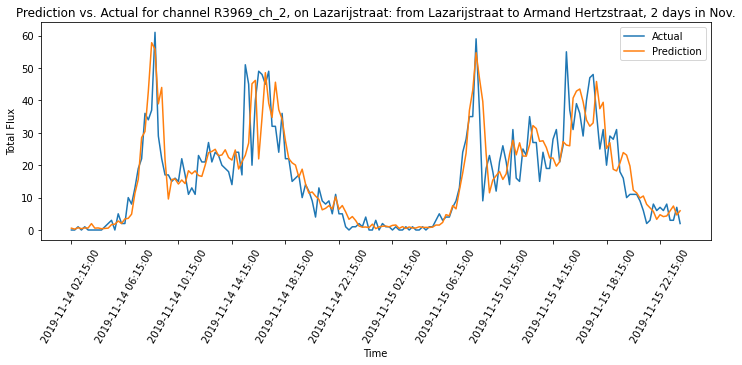

Test RMSE: 9.275
Test R^2: 0.545


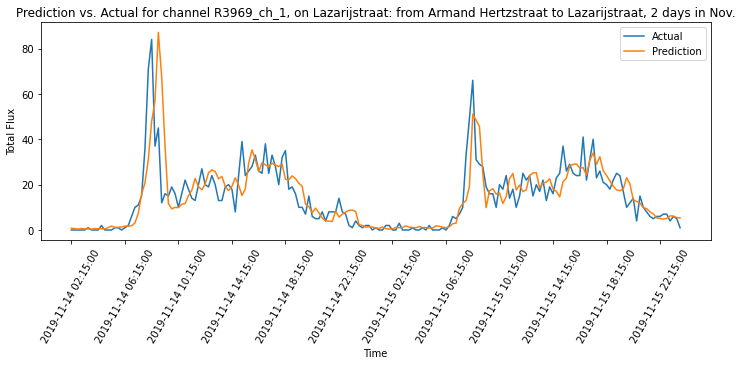

Test RMSE: 5.137
Test R^2: 0.795


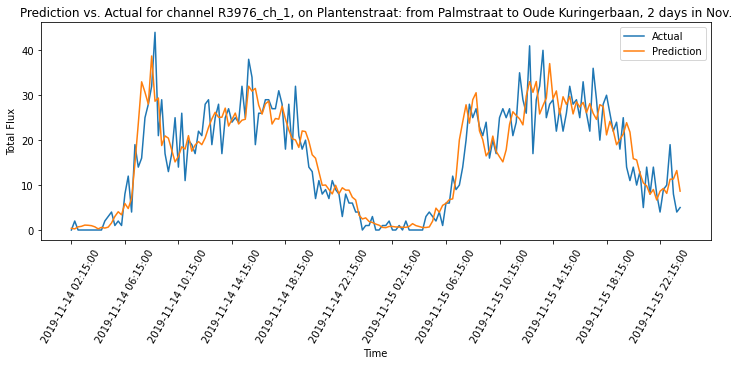

Test RMSE: 5.193
Test R^2: 0.697


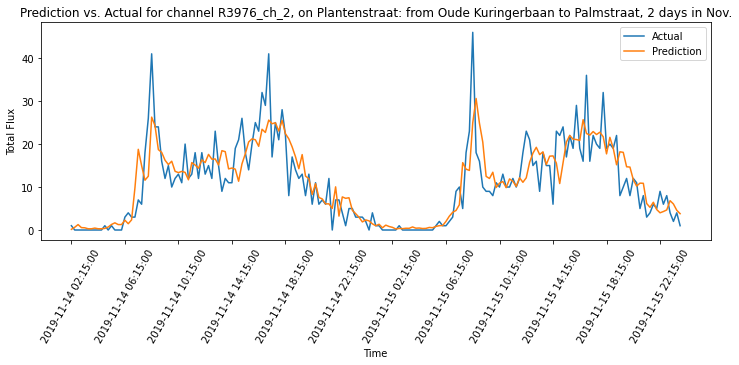

Test RMSE: 7.531
Test R^2: 0.830


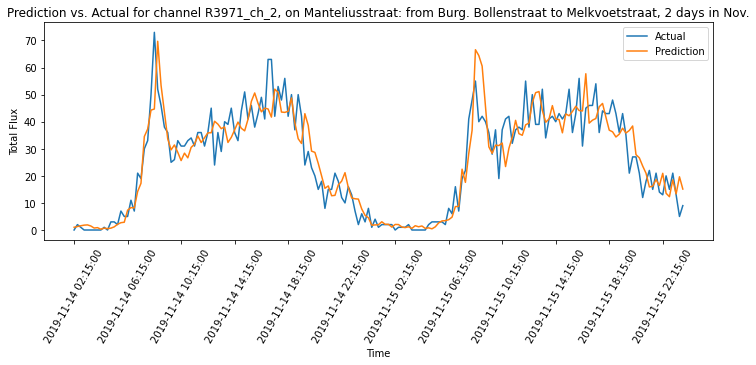

Test RMSE: 5.297
Test R^2: -44.207


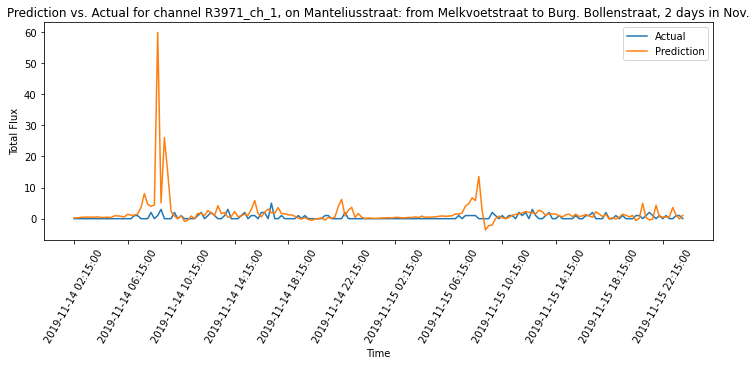

Test RMSE: 9.997
Test R^2: 0.642


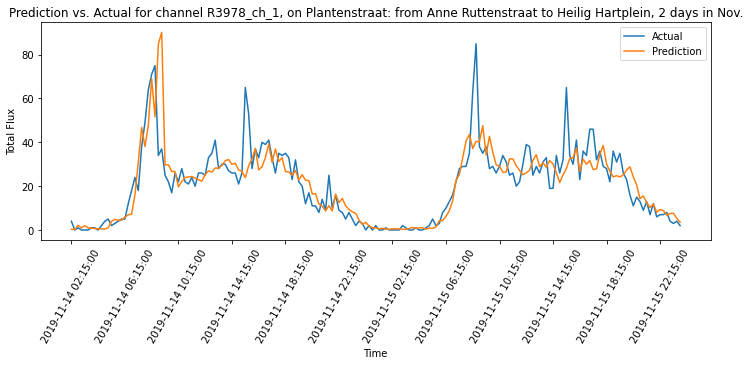

Test RMSE: 3.971
Test R^2: 0.664


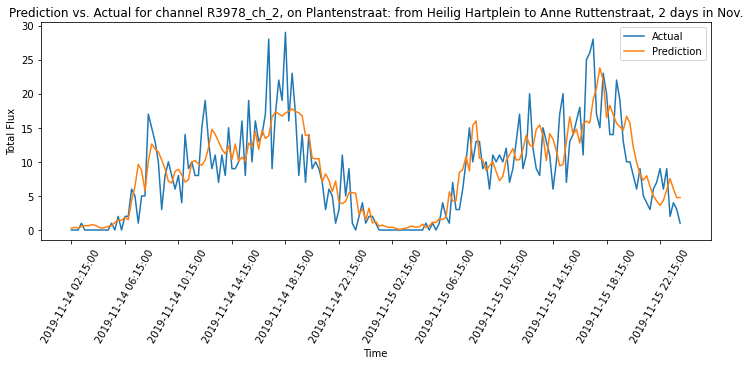

Test RMSE: 3.729
Test R^2: 0.750


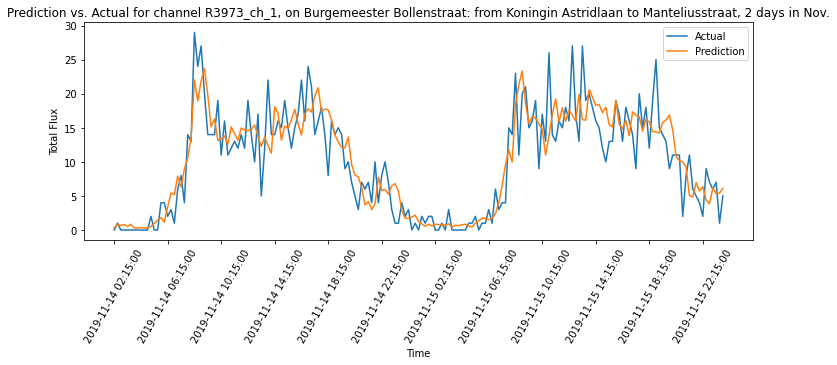

Test RMSE: 5.042
Test R^2: 0.270


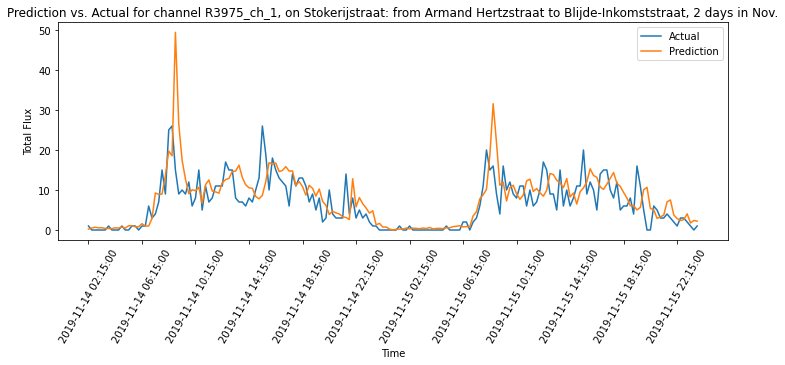

Test RMSE: 3.908
Test R^2: -0.267


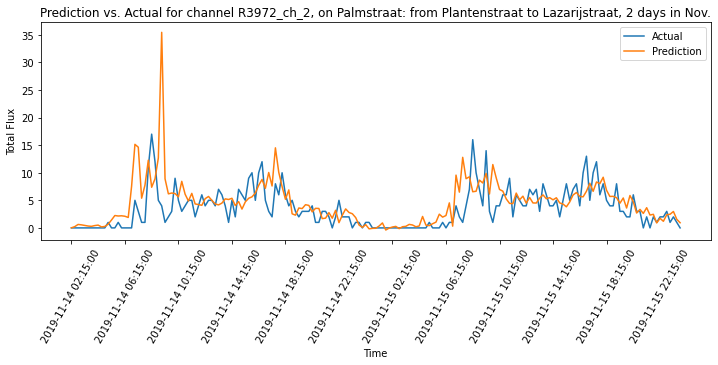

Test RMSE: 8.550
Test R^2: 0.789


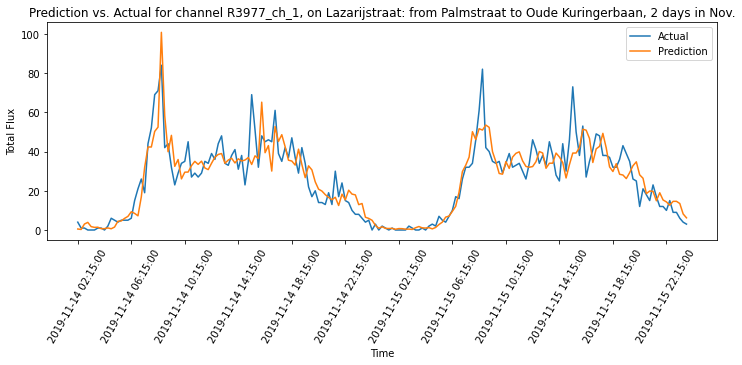

Test RMSE: 3.753
Test R^2: 0.358


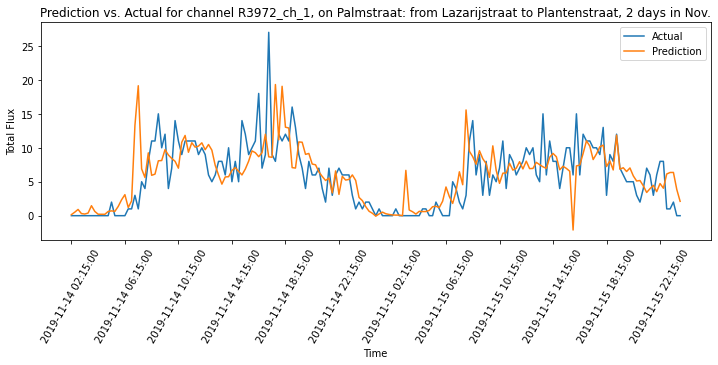

In [22]:
for key in dict_test_df_hasselt_nov:
    df_channel = df_channels[df_channels['Channel'] == key]
    street = df_channel['Street'].iloc[0]
    start = df_channel['Start'].iloc[0]
    end = df_channel['End'].iloc[0]    
    
    (test_x_arr, df_test) = dict_test_df_hasselt_nov[key]
    df_test_f32 = df_test.astype('float32')
    data_arr_test = scaler.transform(df_test_f32)
    test_X, test_y = data_arr_test[:, :-1], data_arr_test[:, -1]
    # test_X = test_X.reshape((test_X.shape[0], num_timesteps, num_feaures))
    
    # ---------------- Make a prediction on the test set and evaluate the rusult for Sept. 
    test_y_pred = model.predict(test_X)
    test_y_pred = test_y_pred.reshape((len(test_y_pred), 1))
    # test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, test_y_pred), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_X, test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]

    # calculate RMSE and R^2
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    r2 = r2_score(inv_y, inv_yhat)
    print('Test RMSE: %.3f' % rmse)
    print('Test R^2: %.3f' % r2)

    # Plot the prediction vs. test set
    plt.figure(figsize=(12, 4))
    plt.title(f'Prediction vs. Actual for channel {key}, on {street}: from {start} to {end}, 2 days in Nov.', fontsize=12)
    plt.plot(inv_y, label="Actual")
    plt.plot(inv_yhat, label="Prediction")
    plt.xticks(np.arange(0, len(test_x_arr), step=16),test_x_arr[::16], rotation=60)
    plt.xlabel("Time")
    plt.ylabel("Total Flux")
    plt.legend()
    # plt.grid(True)
    plt.show()    


### Scale the Hasselt and Brussels data by using data specific scalers, respectively

In [23]:
# Generate build set 

# Hasselt data
i = 0
for df_build_for_detector in lst_train_df_hasselt_sept:
    if i == 0:
        df_build_hasselt = df_build_for_detector
    else:
        df_build_hasselt = df_build_hasselt.append(df_build_for_detector, ignore_index=True)
    i += 1

for df_build_for_detector in lst_train_df_hasselt_nov:
    df_build_hasselt = df_build_hasselt.append(df_build_for_detector, ignore_index=True)

print(df_build_hasselt.shape)

# Brussels data
i = 0
for df_build_for_detector in lst_train_df:
    if i == 0:
        df_build_brussels = df_build_for_detector
    else:
        df_build_brussels = df_build_brussels.append(df_build_for_detector, ignore_index=True)
    i += 1

    
print(df_build_brussels.shape)

# Convert dataframe of build set to a Numpy array
df_build_f32_hasselt = df_build_hasselt.astype('float32')
df_build_f32_brussels = df_build_brussels.astype('float32')

scaler_hasselt = StandardScaler()
scaler_brussels = StandardScaler()
arr_build_hasselt = scaler_hasselt.fit_transform(df_build_f32_hasselt)
arr_build_brussels = scaler_brussels.fit_transform(df_build_f32_brussels)


# Then, shuffle the build set and split it into training and validation sets
np.random.shuffle(arr_build_hasselt)
np.random.shuffle(arr_build_brussels)



# split into input and outputs
train_X_hasselt, train_y_hasselt = arr_build_hasselt[:, :-1], arr_build_hasselt[:, -1]
train_X_brussels, train_y_brussels = arr_build_brussels[:, :-1], arr_build_brussels[:, -1]

train_X = np.concatenate((train_X_hasselt, train_X_brussels), axis=0)
train_y = np.concatenate((train_y_hasselt, train_y_brussels), axis=0)

# valid_X, valid_y = arr_valid[:, :-1], arr_valid[:, -1]

print(train_X.shape, train_y.shape)


(34560, 113)
(15176, 113)
(49736, 112) (49736,)


In [24]:
model_2 = xgb.XGBRegressor()

# param_grid = {
#     'n_estimators': [100, 200, 300, 400],
#     'colsample_bytree': [0.2, 0.3, 0.4, 0.5, 0.6],
#     'max_depth': [5, 6, 8, 10, 12],
#     # 'reg_alpha': [1.1, 1.2, 1.3],
#     # 'reg_lambda': [1.1, 1.2, 1.3],
#     # 'subsample': [0.7, 0.8, 0.9]
# }


param_grid = {
    'n_estimators': [400],
    'colsample_bytree': [0.6],
    'max_depth': [8],
    'reg_alpha': [1.3],
    'reg_lambda': [1.3],
#     # 'subsample': [0.7, 0.8, 0.9]
}

model_2 = algorithm_pipeline(train_X, train_y, model_2, param_grid, cv=10)    

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.9min remaining:   48.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.5min finished


[15:26:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [25]:
# Root Mean Squared Error
print(model_2.best_score_)
print(model_2.best_params_)    

0.860514044106328
{'colsample_bytree': 0.6, 'max_depth': 8, 'n_estimators': 400, 'reg_alpha': 1.3, 'reg_lambda': 1.3}


#### Test on Brussels test set

In [26]:
# Create the time series for each channel and pre-process the data
for detector in dict_df_test:
    
    test_x_arr = dict_df_test[detector][0]
    df_detector = dict_df_test[detector][1]

    df_test_f32 = df_detector.astype('float32')
    
    data_arr_test = scaler_brussels.transform(df_test_f32)
    
    test_X, test_y = data_arr_test[:, :-1], data_arr_test[:, -1]
    
    # ---------------- Make a prediction on the test set and evaluate the rusult. 
    test_y_pred = model_2.predict(test_X)
    test_y_pred = test_y_pred.reshape((len(test_y_pred), 1))
    # test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, test_y_pred), axis=1)
    inv_yhat = scaler_brussels.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_X, test_y), axis=1)
    inv_y = scaler_brussels.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]

    # calculate RMSE and R^2
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    r2 = r2_score(inv_y, inv_yhat)
    print('Test RMSE: %.3f' % rmse)
    print('Test R^2: %.3f' % r2)

    # Plot the prediction vs. test set
    plt.figure(figsize=(12, 4))
    plt.title(f'Prediction vs. Actual for detector {detector}', fontsize=12)
    plt.plot(inv_y, label="Actual")
    plt.plot(inv_yhat, label="Prediction")
    plt.xticks(np.arange(0, len(test_x_arr), step=4),test_x_arr[::4], rotation=60)
    plt.xlabel("Time")
    plt.ylabel("Vehicle Counts")
    plt.legend()
    # plt.grid(True)
    plt.show()  

NameError: name 'dict_df_test' is not defined

#### Test on Hasselt data for Sept. 2019

Test RMSE: 3.845
Test R^2: 0.755


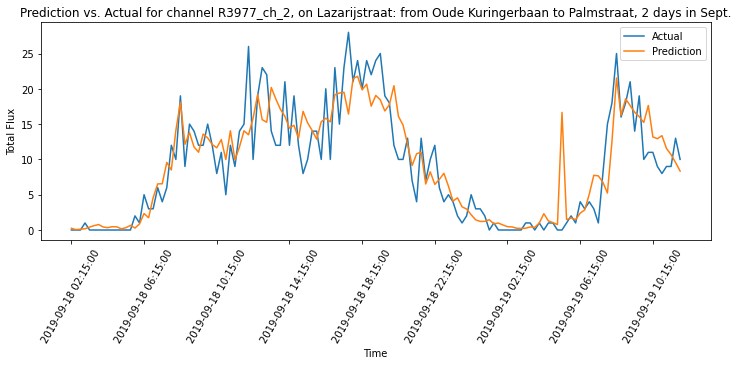

Test RMSE: 4.998
Test R^2: 0.873


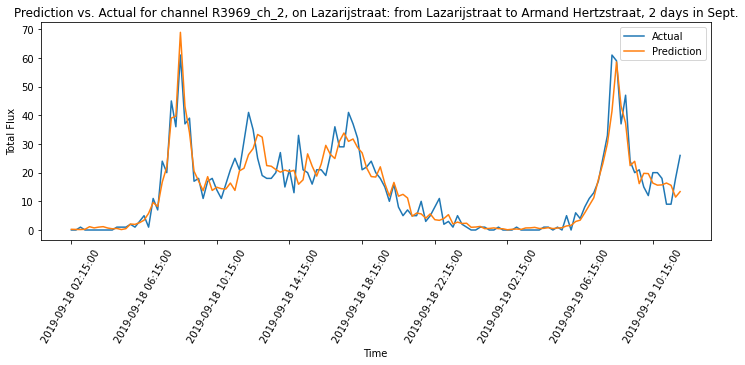

Test RMSE: 6.799
Test R^2: 0.781


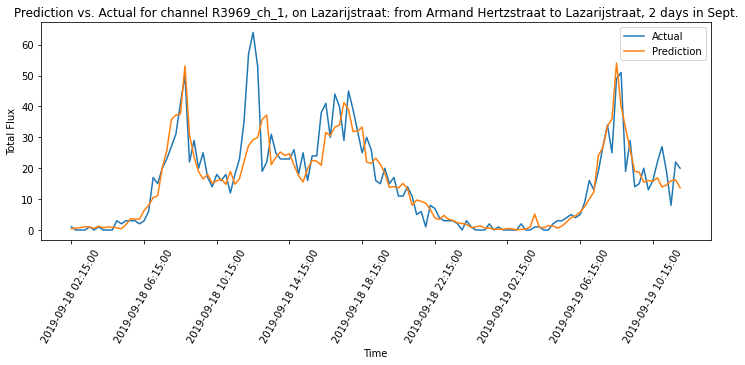

Test RMSE: 3.916
Test R^2: 0.785


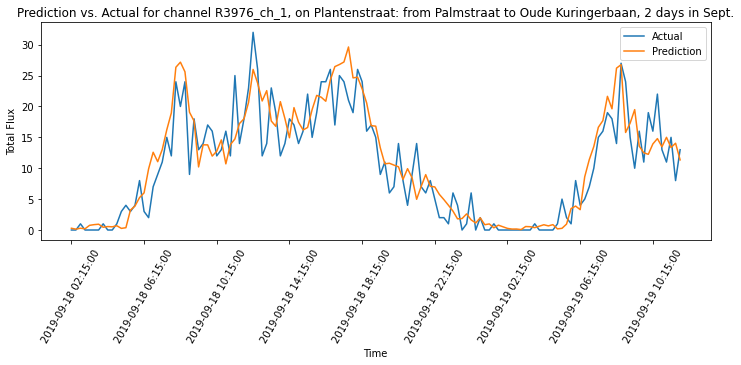

Test RMSE: 4.748
Test R^2: 0.839


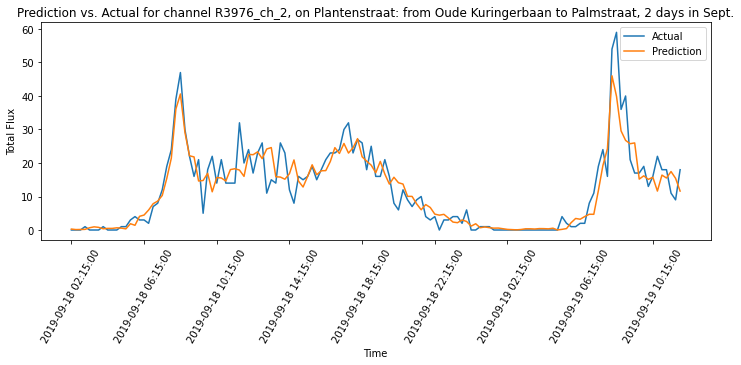

Test RMSE: 5.834
Test R^2: 0.818


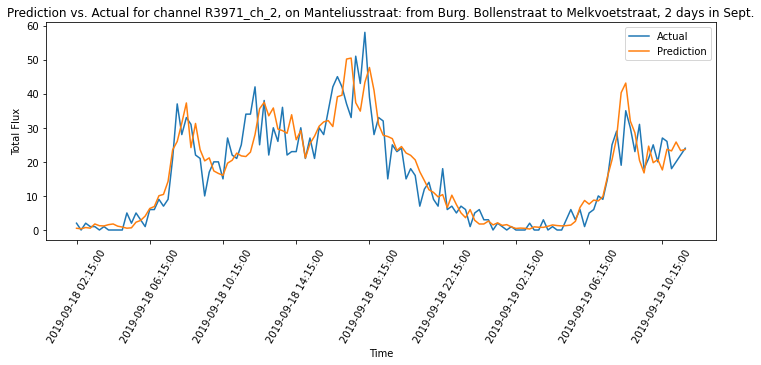

Test RMSE: 5.230
Test R^2: 0.855


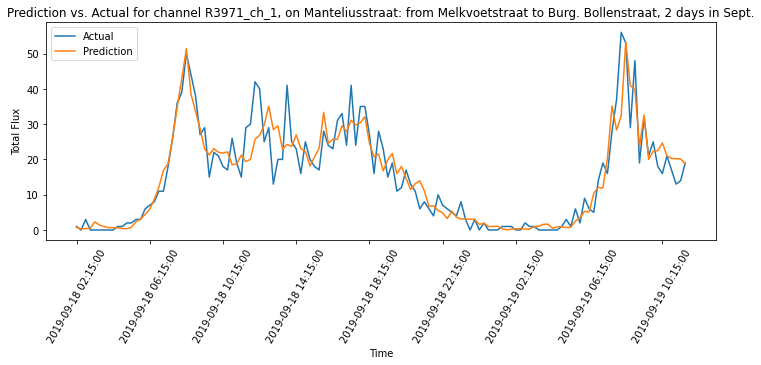

Test RMSE: 4.727
Test R^2: 0.775


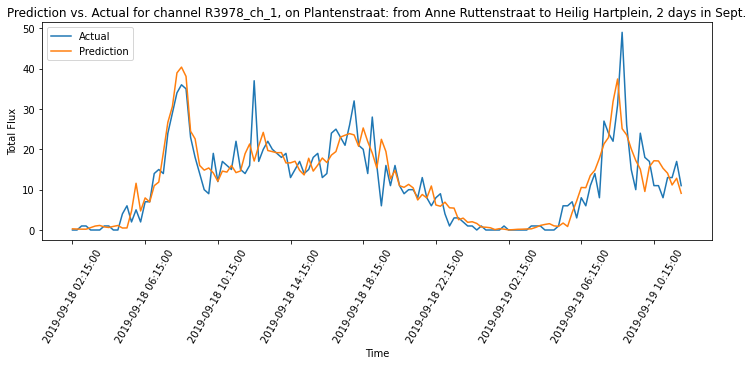

Test RMSE: 2.839
Test R^2: 0.771


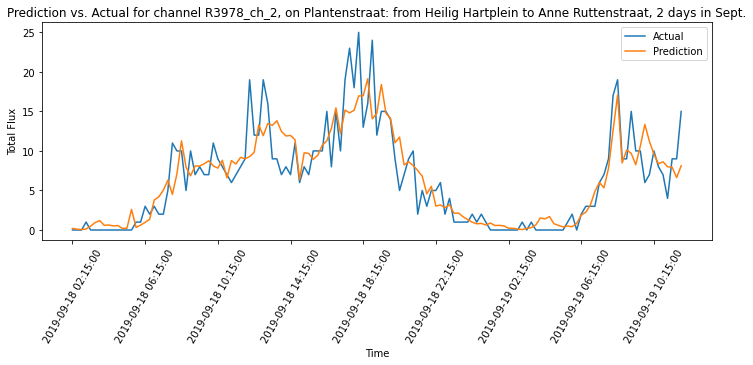

Test RMSE: 4.672
Test R^2: 0.815


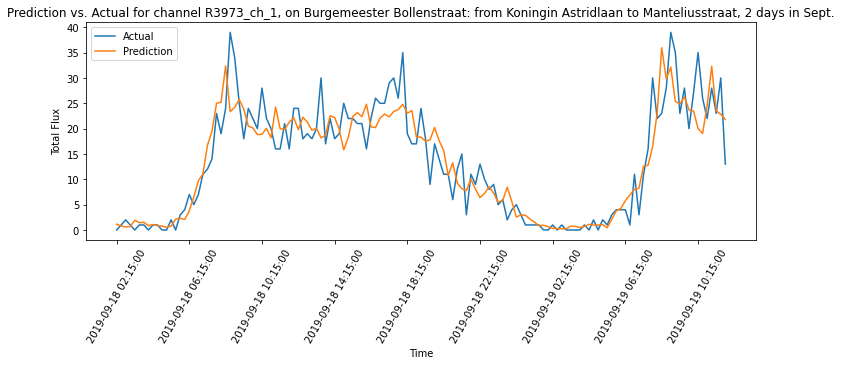

Test RMSE: 6.246
Test R^2: 0.834


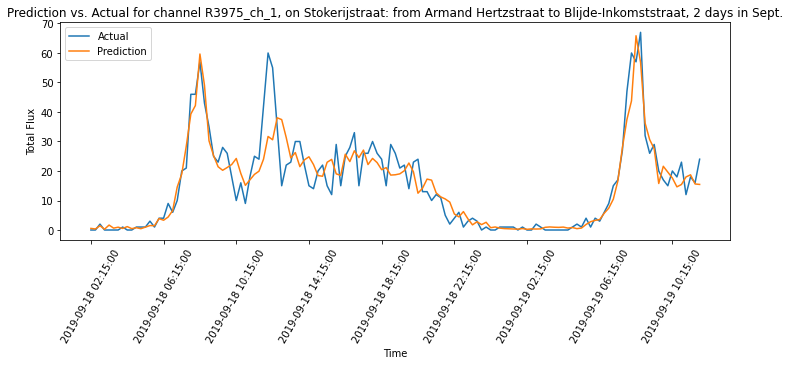

Test RMSE: 2.153
Test R^2: 0.530


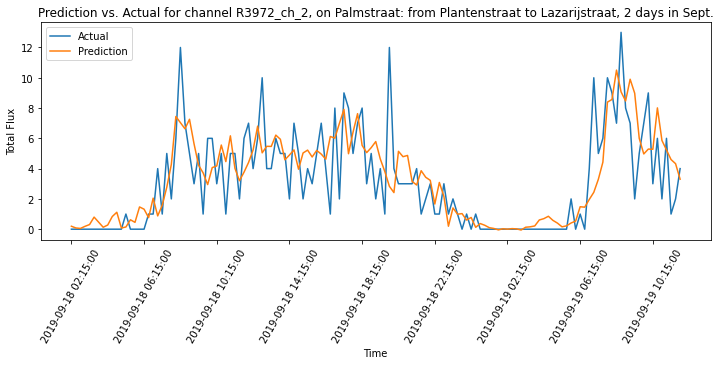

Test RMSE: 5.030
Test R^2: 0.830


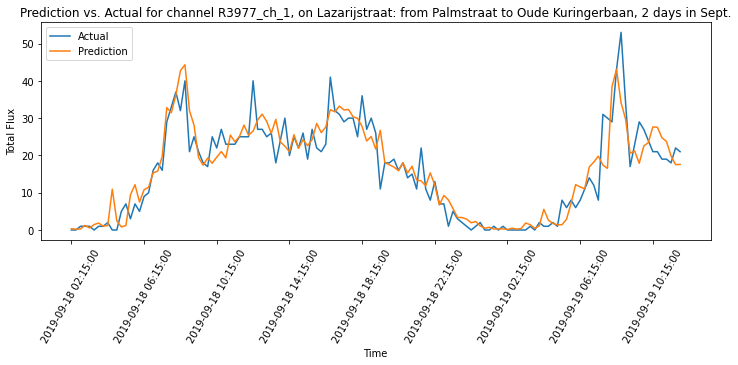

Test RMSE: 2.694
Test R^2: 0.690


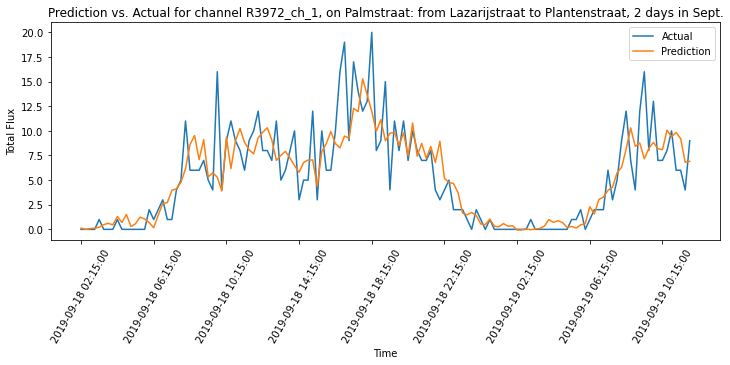

In [27]:
for key in dict_test_df_hasselt_sept:
    df_channel = df_channels[df_channels['Channel'] == key]
    street = df_channel['Street'].iloc[0]
    start = df_channel['Start'].iloc[0]
    end = df_channel['End'].iloc[0]
  
    (test_x_arr, df_test) = dict_test_df_hasselt_sept[key]
    df_test_f32 = df_test.astype('float32')
    data_arr_test = scaler_hasselt.transform(df_test_f32)
    test_X, test_y = data_arr_test[:, :-1], data_arr_test[:, -1]
    # test_X = test_X.reshape((test_X.shape[0], num_timesteps, num_feaures))
    
    # ---------------- Make a prediction on the test set and evaluate the rusult for Sept. 
    test_y_pred = model_2.predict(test_X)
    test_y_pred = test_y_pred.reshape((len(test_y_pred), 1))
    # test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, test_y_pred), axis=1)
    inv_yhat = scaler_hasselt.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_X, test_y), axis=1)
    inv_y = scaler_hasselt.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]

    # calculate RMSE and R^2
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    r2 = r2_score(inv_y, inv_yhat)
    print('Test RMSE: %.3f' % rmse)
    print('Test R^2: %.3f' % r2)

    # Plot the prediction vs. test set
    plt.figure(figsize=(12, 4))
    plt.title(f'Prediction vs. Actual for channel {key}, on {street}: from {start} to {end}, 2 days in Sept.', fontsize=12)
    plt.plot(inv_y, label="Actual")
    plt.plot(inv_yhat, label="Prediction")
    plt.xticks(np.arange(0, len(test_x_arr), step=16),test_x_arr[::16], rotation=60)
    plt.xlabel("Time")
    plt.ylabel("Total Flux")
    plt.legend()
    # plt.grid(True)
    plt.show()    


#### Test on Hasselt data for Nov. 2019

Test RMSE: 4.543
Test R^2: 0.686


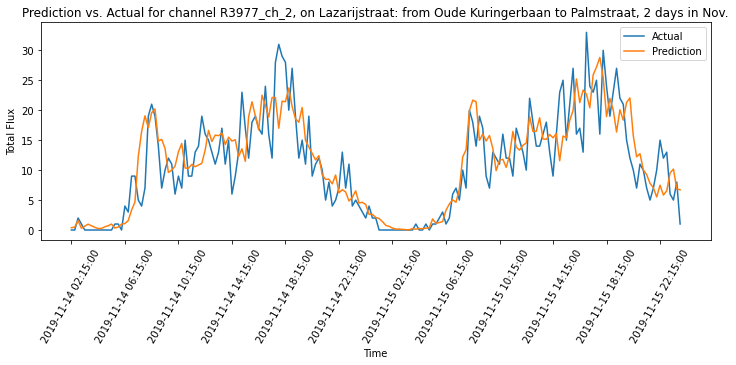

Test RMSE: 6.391
Test R^2: 0.801


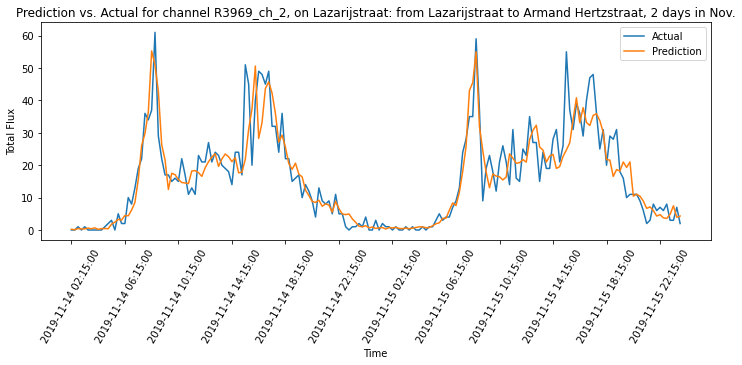

Test RMSE: 6.639
Test R^2: 0.767


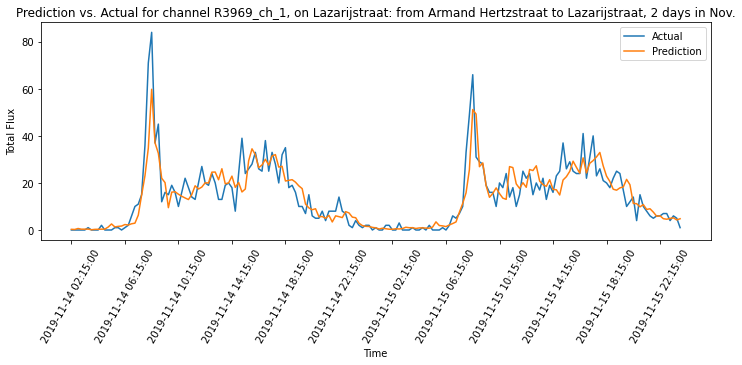

Test RMSE: 4.818
Test R^2: 0.820


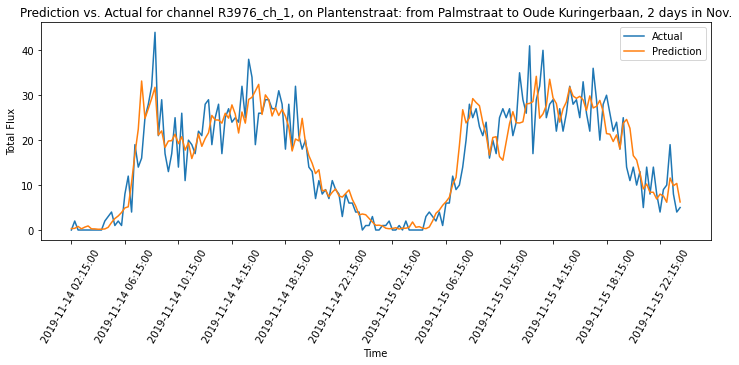

Test RMSE: 4.546
Test R^2: 0.768


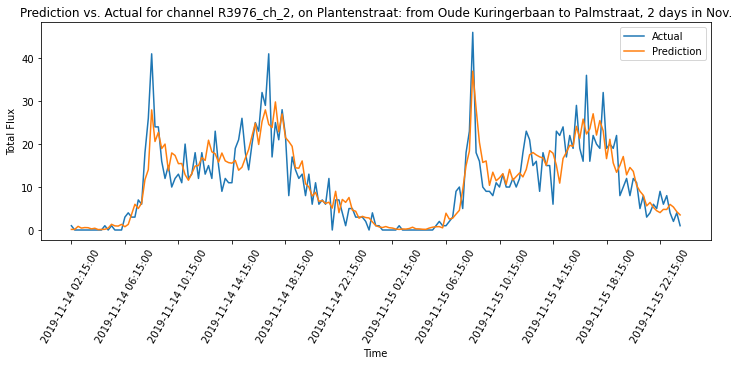

Test RMSE: 6.896
Test R^2: 0.857


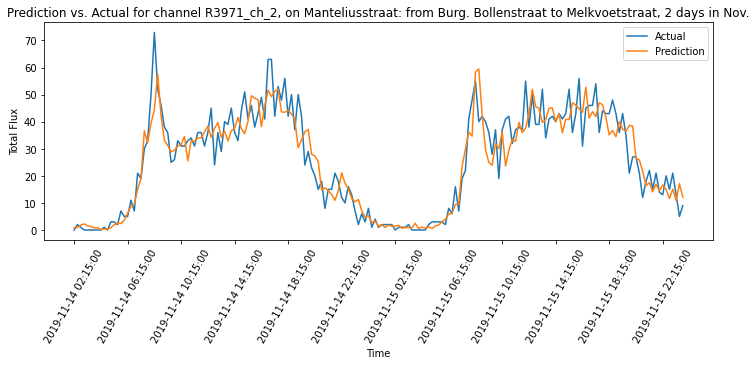

Test RMSE: 0.936
Test R^2: -0.413


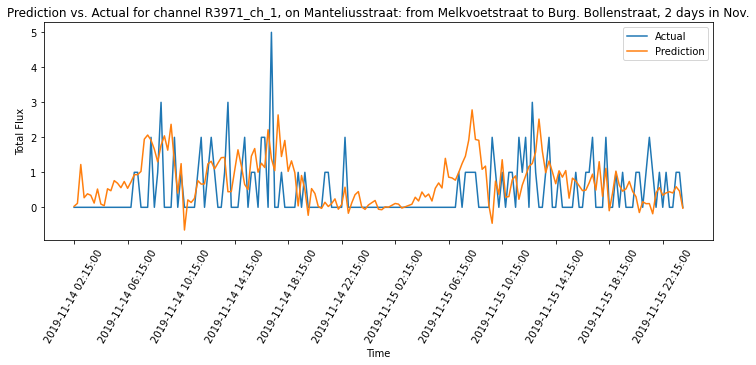

Test RMSE: 8.142
Test R^2: 0.762


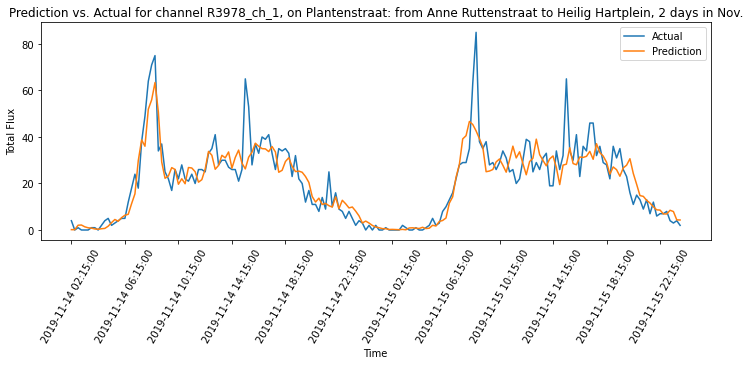

Test RMSE: 4.073
Test R^2: 0.647


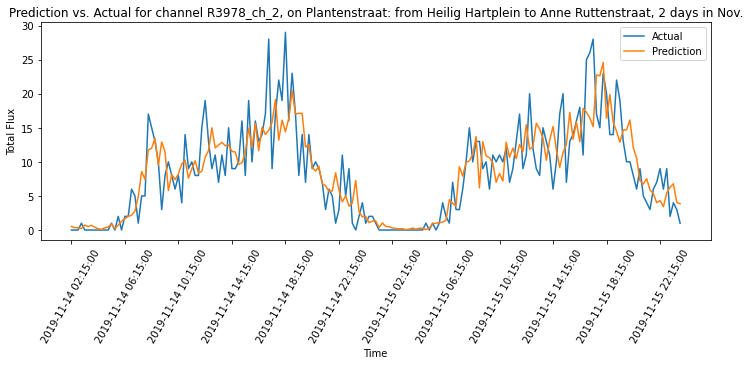

Test RMSE: 3.669
Test R^2: 0.758


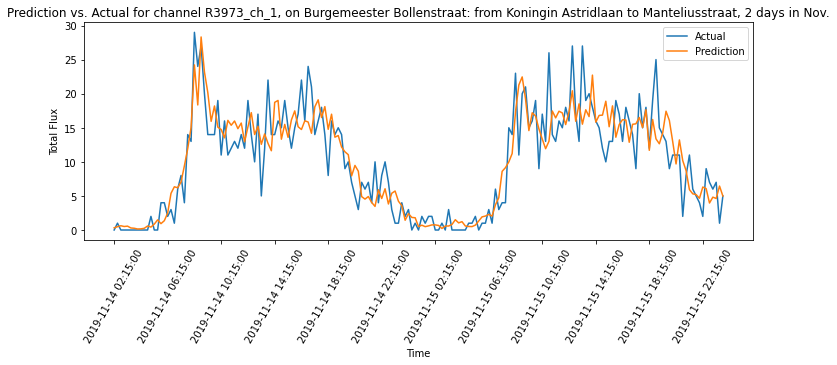

Test RMSE: 4.083
Test R^2: 0.521


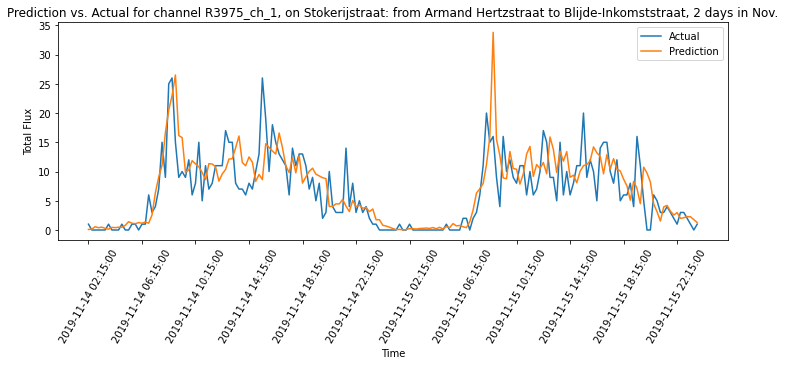

Test RMSE: 2.536
Test R^2: 0.466


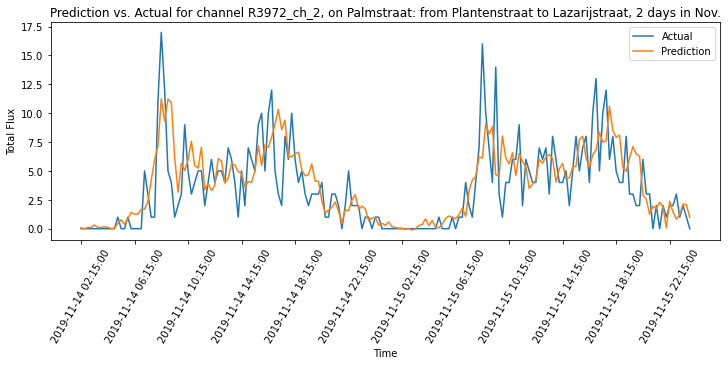

Test RMSE: 8.033
Test R^2: 0.814


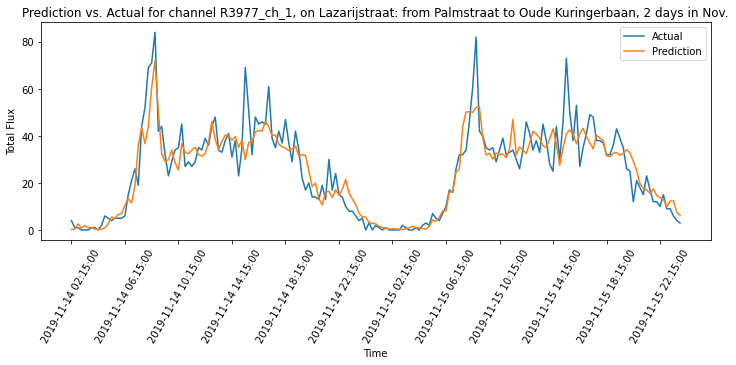

Test RMSE: 2.918
Test R^2: 0.612


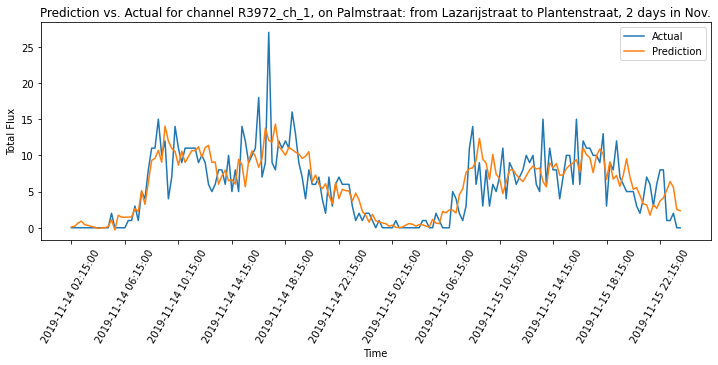

In [28]:
for key in dict_test_df_hasselt_nov:
    df_channel = df_channels[df_channels['Channel'] == key]
    street = df_channel['Street'].iloc[0]
    start = df_channel['Start'].iloc[0]
    end = df_channel['End'].iloc[0]    
    
    (test_x_arr, df_test) = dict_test_df_hasselt_nov[key]
    df_test_f32 = df_test.astype('float32')
    data_arr_test = scaler_hasselt.transform(df_test_f32)
    test_X, test_y = data_arr_test[:, :-1], data_arr_test[:, -1]
    # test_X = test_X.reshape((test_X.shape[0], num_timesteps, num_feaures))
    
    # ---------------- Make a prediction on the test set and evaluate the rusult for Sept. 
    test_y_pred = model_2.predict(test_X)
    test_y_pred = test_y_pred.reshape((len(test_y_pred), 1))
    # test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, test_y_pred), axis=1)
    inv_yhat = scaler_hasselt.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_X, test_y), axis=1)
    inv_y = scaler_hasselt.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]

    # calculate RMSE and R^2
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    r2 = r2_score(inv_y, inv_yhat)
    print('Test RMSE: %.3f' % rmse)
    print('Test R^2: %.3f' % r2)

    # Plot the prediction vs. test set
    plt.figure(figsize=(12, 4))
    plt.title(f'Prediction vs. Actual for channel {key}, on {street}: from {start} to {end}, 2 days in Nov.', fontsize=12)
    plt.plot(inv_y, label="Actual")
    plt.plot(inv_yhat, label="Prediction")
    plt.xticks(np.arange(0, len(test_x_arr), step=16),test_x_arr[::16], rotation=60)
    plt.xlabel("Time")
    plt.ylabel("Total Flux")
    plt.legend()
    # plt.grid(True)
    plt.show()    